In [ ]:
! pip install pyspark py4j

In [ ]:
import datetime as dt
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Convert Excel format to CSV format.

In [ ]:
#excel_path = '/Users/shalu/Downloads/forecasting_case_study.xlsx - Sheet1.csv'
#csv_output_path = '/content/drive/MyDrive/Data_Glacier/Week7/forecasting_case_study.csv'

df = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week7/forecasting_case_study.csv')

#df.to_csv(csv_output_path, index=False)

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("ReadDataExample").getOrCreate()

Read csv.

In [ ]:
csv_file_path = "/content/drive/MyDrive/Data_Glacier/Week7/forecasting_case_study.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [ ]:
df.show(5)

+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|      date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1|2017-02-05|27750|               0.0|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-12|29023|               0.0|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2017-02-19|45630|              0.17|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-26|26789|               0.0|             1|              0|              1|            0.0|         0|    0|     0|        0|

In [ ]:
display( df )

DataFrame[Product: string, date: date, Sales: int, Price Discount (%): double, In-Store Promo: int, Catalogue Promo: int, Store End Promo: int, Google_Mobility: double, Covid_Flag: int, V_DAY: int, EASTER: int, CHRISTMAS: int]

Check if there are missing values.

In [ ]:
from pyspark.sql.functions import col, isnan, when, count

missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns if df.schema[c].dataType != 'date'])
missing_counts.show()

+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      0|   0|    0|                 0|             0|              0|              0|              0|         0|    0|     0|        0|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+



**Observation**  
No missng values existing

In [ ]:
df.count(), len(df.columns)

(1218, 12)

**Observation**  
1218 observations and 12 columns.

In [ ]:
df.printSchema()

root
 |-- Product: string (nullable = true)
 |-- date: date (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Price Discount (%): double (nullable = true)
 |-- In-Store Promo: integer (nullable = true)
 |-- Catalogue Promo: integer (nullable = true)
 |-- Store End Promo: integer (nullable = true)
 |-- Google_Mobility: double (nullable = true)
 |-- Covid_Flag: integer (nullable = true)
 |-- V_DAY: integer (nullable = true)
 |-- EASTER: integer (nullable = true)
 |-- CHRISTMAS: integer (nullable = true)



**Observation**   
PySpark does not support "categorical" data type. So, we don't convert the data type for "In-Store Promo", "Catalogue Promo", "Store End Promo", "Covid_Flag", "V_DAY", "EASTER", and "CHRISTMAS".  In general, PySpark uses "string" and "integer" for "categorical" values.  

In [ ]:
df.select("Sales", "Google_Mobility")

DataFrame[Sales: int, Google_Mobility: double]

Validate the name of columns. Put _ between word in stead of space.

In [ ]:
df = (
    df
    .withColumnRenamed("Price Discount (%)", "Price_Discount_(%)")
    .withColumnRenamed("In-Store Promo", "In-Store_Promo")
    .withColumnRenamed("Catalogue Promo", "Catalogue_Promo")
    .withColumnRenamed("Store End Promo", "Store_End_Promo")
)

In [ ]:
df.show(5)

+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|      date|Sales|Price_Discount_(%)|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1|2017-02-05|27750|               0.0|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-12|29023|               0.0|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2017-02-19|45630|              0.17|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-26|26789|               0.0|             1|              0|              1|            0.0|         0|    0|     0|        0|

In [ ]:
duplicates = df.groupBy("Product").count().filter(col("count") > 1)
duplicates.show()

+-------+-----+
|Product|count|
+-------+-----+
|   SKU3|  204|
|   SKU4|  204|
|   SKU1|  204|
|   SKU5|  204|
|   SKU6|  198|
|   SKU2|  204|
+-------+-----+



**Observation**  
6products with only SKU6 has 198 counts while others are 204 counts.   

In [ ]:
description = df.describe()
description.show()

+-------+-------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|summary|Product|             Sales| Price_Discount_(%)|    In-Store_Promo|    Catalogue_Promo|    Store_End_Promo|    Google_Mobility|         Covid_Flag|               V_DAY|              EASTER|           CHRISTMAS|
+-------+-------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|  count|   1218|              1218|               1218|              1218|               1218|               1218|               1218|               1218|                1218|                1218|                1218|
|   mean|   null|30294.678981937603| 0.2510426929392443|0.4720853858784893|0.21264367816091953|0.34893267651888343|-2.377405

In [ ]:
df = df.withColumn("Sales", col("Sales").cast(IntegerType()))

In [ ]:
df.describe().toPandas()

,summary,Product,Sales,Price_Discount_(%),In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,count,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218
1,mean,None,30294.678981937603,0.2510426929392443,0.4720853858784893,0.21264367816091953,0.34893267651888343,-2.3774055829228224,0.22660098522167488,0.019704433497536946,0.019704433497536946,0.018883415435139574
2,stddev,None,35032.5272965258,0.21549350172360285,0.4994252268419534,0.40934571855807333,0.47682841234861867,5.806290981009834,0.4188042296935616,0.13903970926580328,0.13903970926580325,0.13616921612117958
3,min,SKU1,0,0.0,0,0,0,-28.49,0,0,0,0
4,max,SKU6,288322,0.83,1,1,1,3.9,1,1,1,1


PySpark is not good at Visualization. So, we convert it to pandas format to plot graphs.

In [ ]:
pandas_df = df.toPandas()

In [ ]:
pandas_df.describe(include= ['object']).T

,count,unique,top,freq
Product,1218,6,SKU1,204
date,1218,204,2017-02-05,6


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()

In [ ]:
df.head()

Row(Product='SKU1', date=datetime.date(2017, 2, 5), Sales=27750, Price_Discount_(%)=0.0, In-Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility=0.0, Covid_Flag=0, V_DAY=0, EASTER=0, CHRISTMAS=0)

<Axes: xlabel='date', ylabel='Sales'>

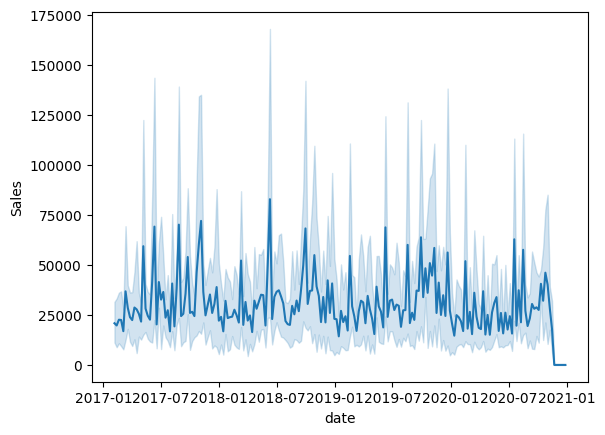

In [ ]:
sns.lineplot(x = 'date', y = 'Sales', data=pandas_df)

In [ ]:
df=spark.read.option("header",True) \
        .csv("/content/drive/MyDrive/Data_Glacier/Week7/forecasting_case_study.csv")

In [ ]:
df.write.option("header", True) \
        .partitionBy("Product") \
        .mode("overwrite") \
        .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast")

In [ ]:
dfSinglePart=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU1")

In [ ]:
dfSinglePart2=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU2")

In [ ]:
dfSinglePart3=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU3")

In [ ]:
dfSinglePart4=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU4")

In [ ]:
dfSinglePart5=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU5")

In [ ]:
dfSinglePart6=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU6")

In [ ]:
def histplot_boxplot(feature, figsize=(15, 10), bins=None):
    """ Boxplot and histogram combined

    feature: 1-d feature array

    figsize: size of fig (default (9, 8))

    bins: number of bins (default None / auto)

    """
    f2, (ax_box2, ax_his2) = plt.subplots(nrows=2,  # Number of rows of the subplot grid = 2
                                           sharex=True,  # X-axis will be shared among all subplots
                                           gridspec_kw={"height_ratios": (.25, .75)},
                                           figsize=figsize
                                           )  # Creating the 2 subplots

    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet')  # Boxplot will be created and a symbol will indicate the mean value of the column

    if bins:
        sns.histplot(x=feature, kde=True, ax=ax_his2, bins=bins, palette="winter")  # For histogram
    else:
        sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram

    ax_his2.axvline(np.mean(feature), color='green', linestyle='--')  # Add mean to the histogram

    ax_his2.axvline(np.median(feature), color='black', linestyle='-')  # Add median to the histogram


In [ ]:
dfSinglePart.printSchema()
dfSinglePart.show()
df1= dfSinglePart.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date| Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05| 27750|               0.0|             0|              0|              0|            0.0|         0|    0|

In [ ]:
dfSinglePart2.printSchema()
dfSinglePart2.show()
df2= dfSinglePart2.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05| 7180|              0.25|             1|              0|              0|            0.0|         0|    0|    

In [ ]:
dfSinglePart3.printSchema()
dfSinglePart3.show()
df3= dfSinglePart3.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date| Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05| 39767|               0.3|             0|              1|              1|            0.0|         0|    0|

In [ ]:
dfSinglePart4.printSchema()
dfSinglePart4.show()
df4= dfSinglePart4.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05|12835|               0.3|             0|              1|              1|            0.0|         0|    0|    

In [ ]:
dfSinglePart5.printSchema()
dfSinglePart5.show()
df5= dfSinglePart5.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05| 5229|               0.0|             0|              0|              0|            0.0|         0|    0|    

In [ ]:
dfSinglePart6.printSchema()
dfSinglePart6.show()
df6= dfSinglePart6.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date| Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05| 32138|              0.28|             0|              0|              0|            0.0|         0|    0|

In [ ]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df1['Price Discount (%)'] = df1['Price Discount (%)'].apply(convert_to_int)

In [ ]:
#df1['Price Discount (%)']= df1['Price Discount (%)'].str[:-1]
#df1['Price Discount (%)']= df1['Price Discount (%)'].astype(int)

In [ ]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df2['Price Discount (%)'] = df2['Price Discount (%)'].apply(convert_to_int)

In [ ]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df3['Price Discount (%)'] = df3['Price Discount (%)'].apply(convert_to_int)

In [ ]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df4['Price Discount (%)'] = df4['Price Discount (%)'].apply(convert_to_int)

In [ ]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df5['Price Discount (%)'] = df5['Price Discount (%)'].apply(convert_to_int)

In [ ]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df6['Price Discount (%)'] = df6['Price Discount (%)'].apply(convert_to_int)

In [ ]:
df1.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [ ]:
df2.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [ ]:
df3.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [ ]:
df4.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [ ]:
df5.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [ ]:
df6.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [ ]:

cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df1[cols]=df1[cols].apply(pd.to_numeric)
df1['date']=df1['date'].apply(pd.to_datetime)
#df1=df1[df1['Sales'] !=0]

In [ ]:
cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df2[cols]=df2[cols].apply(pd.to_numeric)
df2['date']=df2['date'].apply(pd.to_datetime)

In [ ]:
cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df3[cols]=df3[cols].apply(pd.to_numeric)
df3['date']=df3['date'].apply(pd.to_datetime)

In [ ]:
cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df4[cols]=df4[cols].apply(pd.to_numeric)
df4['date']=df4['date'].apply(pd.to_datetime)

In [ ]:
cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df5[cols]=df5[cols].apply(pd.to_numeric)
df5['date']=df5['date'].apply(pd.to_datetime)

In [ ]:
cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df6[cols]=df6[cols].apply(pd.to_numeric)
df6['date']=df6['date'].apply(pd.to_datetime)

In [ ]:
df1.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
199,2020-11-29,0,0,1,0,1,-5.30,1,0,0,0
200,2020-12-06,0,0,1,0,1,-4.38,1,0,0,0
201,2020-12-13,0,0,1,0,1,-4.74,1,0,0,0
202,2020-12-20,0,0,1,0,1,-10.27,1,0,0,1
203,2020-12-27,0,0,1,0,0,-6.95,1,0,0,0


In [ ]:
df2.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
199,2020-11-29,0,0,1,0,0,-5.30,1,0,0,0
200,2020-12-06,0,0,0,0,0,-4.38,1,0,0,0
201,2020-12-13,0,0,0,0,0,-4.74,1,0,0,0
202,2020-12-20,0,0,0,0,0,-10.27,1,0,0,1
203,2020-12-27,0,0,0,0,0,-6.95,1,0,0,0


In [ ]:
df3.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
199,2020-11-29,0,0,0,1,0,-5.30,1,0,0,0
200,2020-12-06,0,0,1,0,0,-4.38,1,0,0,0
201,2020-12-13,0,0,0,1,0,-4.74,1,0,0,0
202,2020-12-20,0,0,0,1,0,-10.27,1,0,0,1
203,2020-12-27,0,0,1,0,1,-6.95,1,0,0,0


In [ ]:
df4.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
199,2020-11-29,0,0,0,1,0,-5.30,1,0,0,0
200,2020-12-06,0,0,1,0,0,-4.38,1,0,0,0
201,2020-12-13,0,0,0,1,0,-4.74,1,0,0,0
202,2020-12-20,0,0,0,1,0,-10.27,1,0,0,1
203,2020-12-27,0,0,1,0,1,-6.95,1,0,0,0


In [ ]:
df5.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
199,2020-11-29,0,0,0,0,0,-5.30,1,0,0,0
200,2020-12-06,0,0,1,0,0,-4.38,1,0,0,0
201,2020-12-13,0,0,1,0,0,-4.74,1,0,0,0
202,2020-12-20,0,0,1,0,0,-10.27,1,0,0,1
203,2020-12-27,0,0,0,0,0,-6.95,1,0,0,0


In [ ]:
df6.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
193,2020-10-18,96619,0,0,1,0,-7.56,1,0,0,0
194,2020-10-25,115798,0,0,1,0,-8.39,1,0,0,0
195,2020-11-01,152186,0,1,0,1,-7.43,1,0,0,0
196,2020-11-08,26445,0,1,0,1,-5.95,1,0,0,0
197,2020-11-15,26414,0,0,0,0,-7.20,1,0,0,0


<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


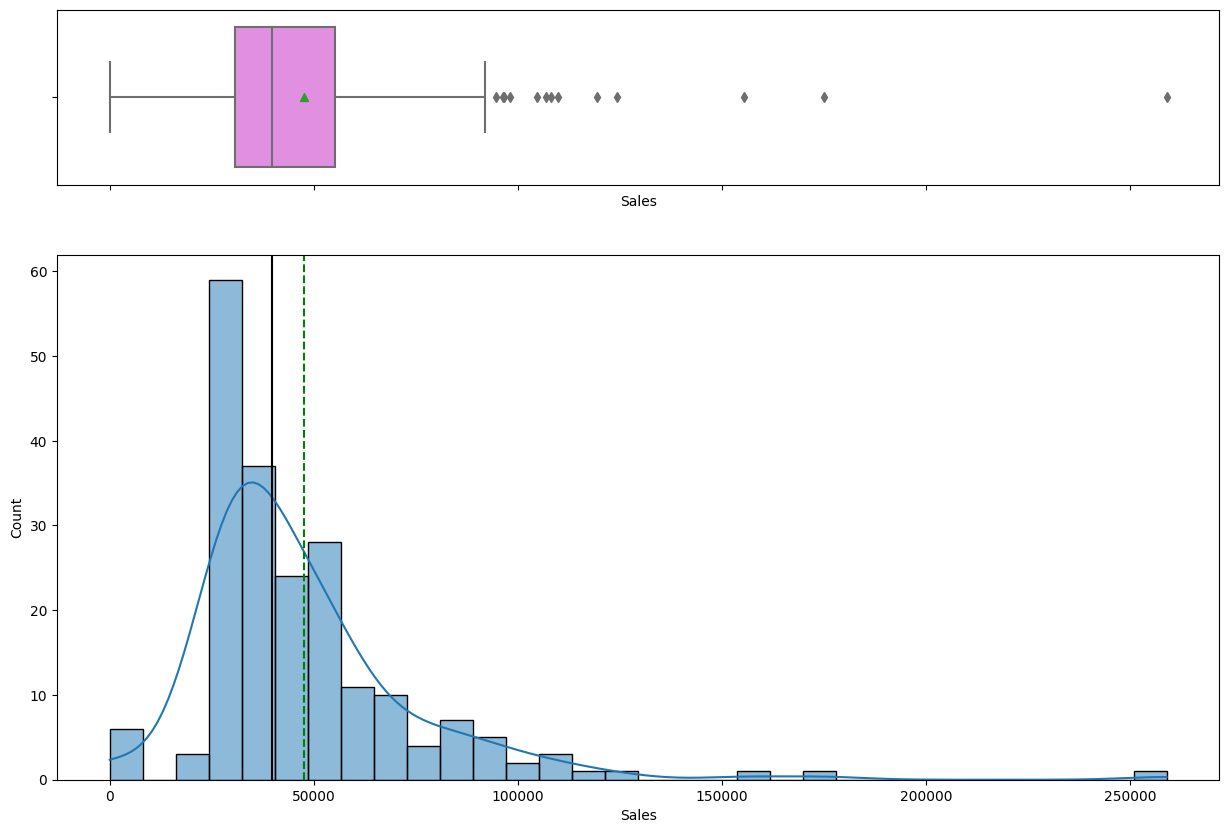

In [ ]:
histplot_boxplot(df1['Sales'])

In [ ]:
df1.describe()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,204.000000,204.0,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,47521.901961,0.0,0.421569,0.088235,0.259804,-2.396471,0.230392,0.019608,0.019608,0.019608
std,29187.725878,0.0,0.495025,0.284335,0.439606,5.811945,0.422120,0.138989,0.138989,0.138989
min,0.000000,0.0,0.000000,0.000000,0.000000,-28.490000,0.000000,0.000000,0.000000,0.000000
25%,30795.750000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39627.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55269.750000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,258874.000000,0.0,1.000000,1.000000,1.000000,3.900000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#q_hi  = df1['Sales'].quantile(0.99)
Q1 = np.percentile(df1['Sales'], 25, method='midpoint')
Q3 = np.percentile(df1['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df1 = df1[(df1['Sales'] < upper)]

24606.0


In [ ]:
df1_exclude= df1.iloc[:, 1:]

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


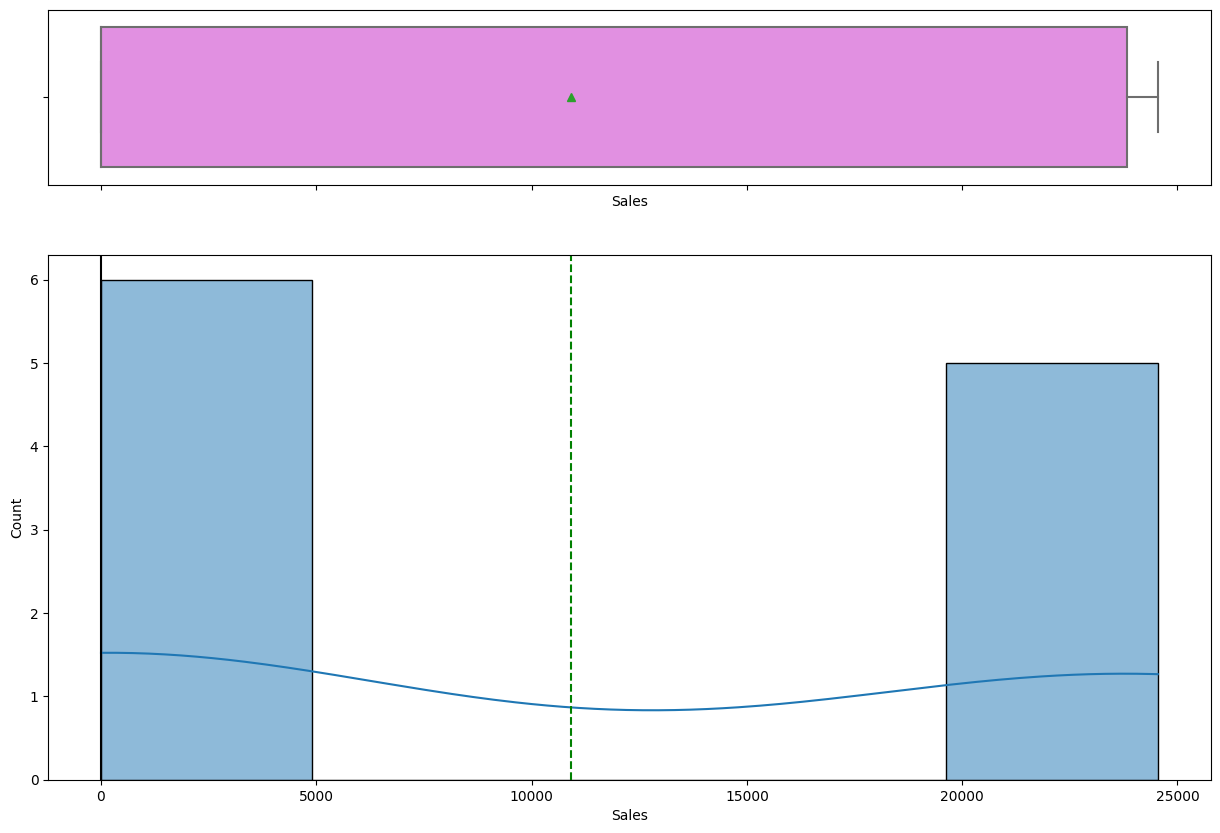

In [ ]:
histplot_boxplot(df1['Sales'])

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


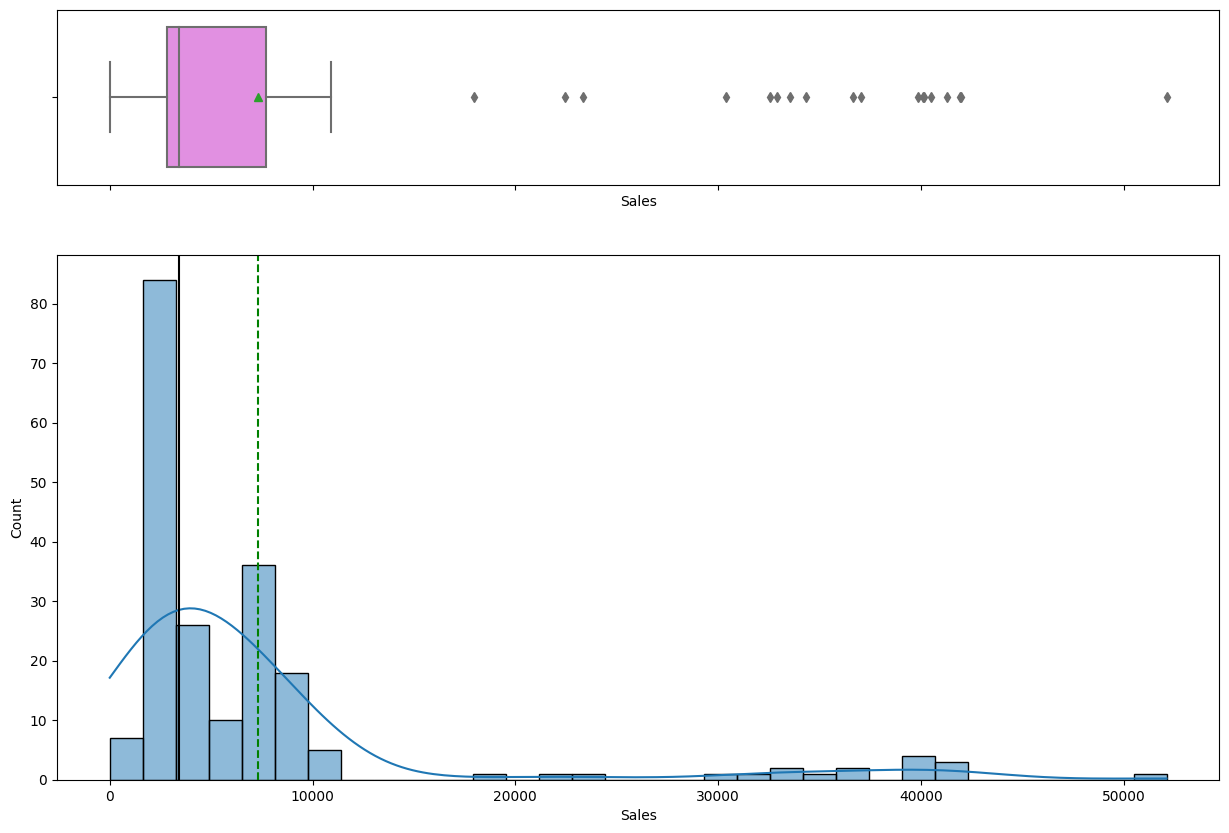

In [ ]:
histplot_boxplot(df2['Sales'])

In [ ]:
df2.describe()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,204.000000,204.0,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,7304.666667,0.0,0.308824,0.127451,0.044118,-2.396471,0.230392,0.019608,0.019608,0.019608
std,9434.975581,0.0,0.463145,0.334298,0.205862,5.811945,0.422120,0.138989,0.138989,0.138989
min,0.000000,0.0,0.000000,0.000000,0.000000,-28.490000,0.000000,0.000000,0.000000,0.000000
25%,2820.750000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3392.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7702.250000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,52122.000000,0.0,1.000000,1.000000,1.000000,3.900000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#q_hi  = df1['Sales'].quantile(0.99)
Q1 = np.percentile(df2['Sales'], 25, method='midpoint')
Q3 = np.percentile(df2['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df2 = df2[(df2['Sales'] < upper)]

4891.0


In [ ]:
df2_exclude= df2.iloc[:, 1:]

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


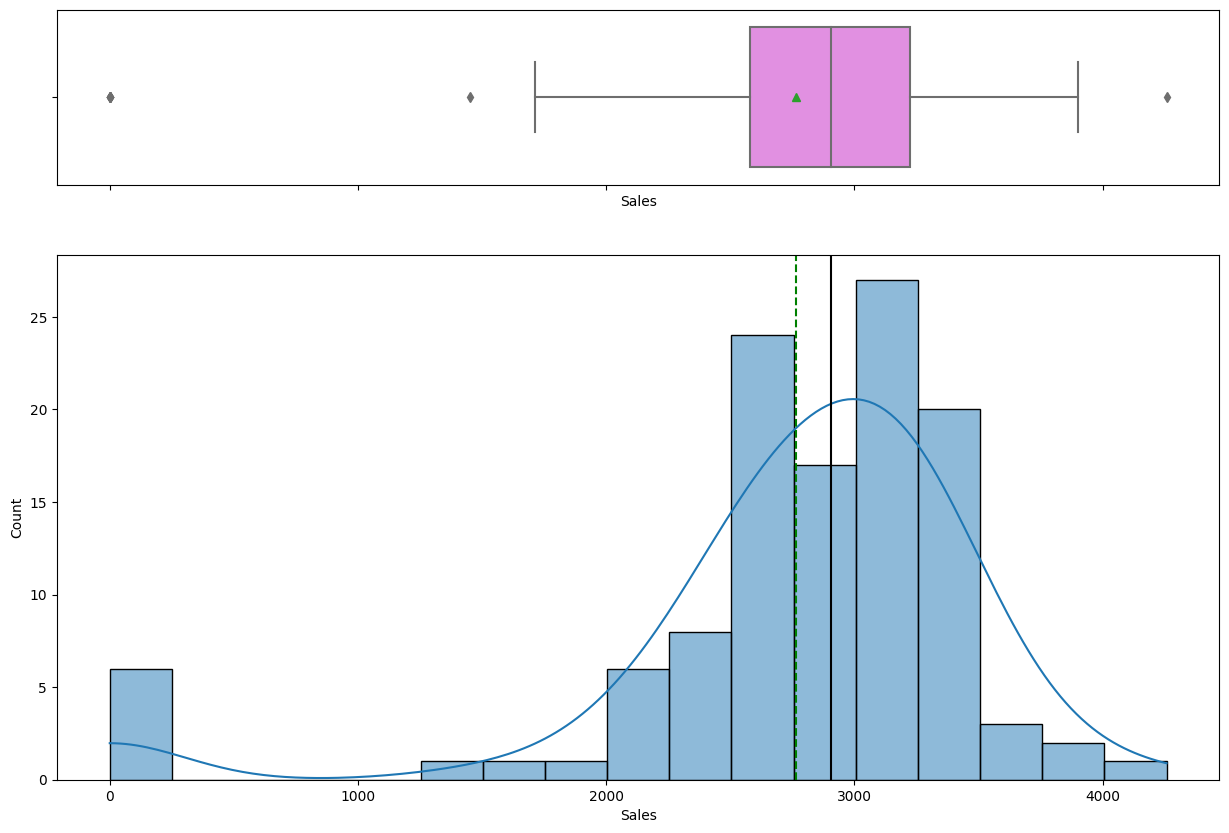

In [ ]:
histplot_boxplot(df2['Sales'])

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


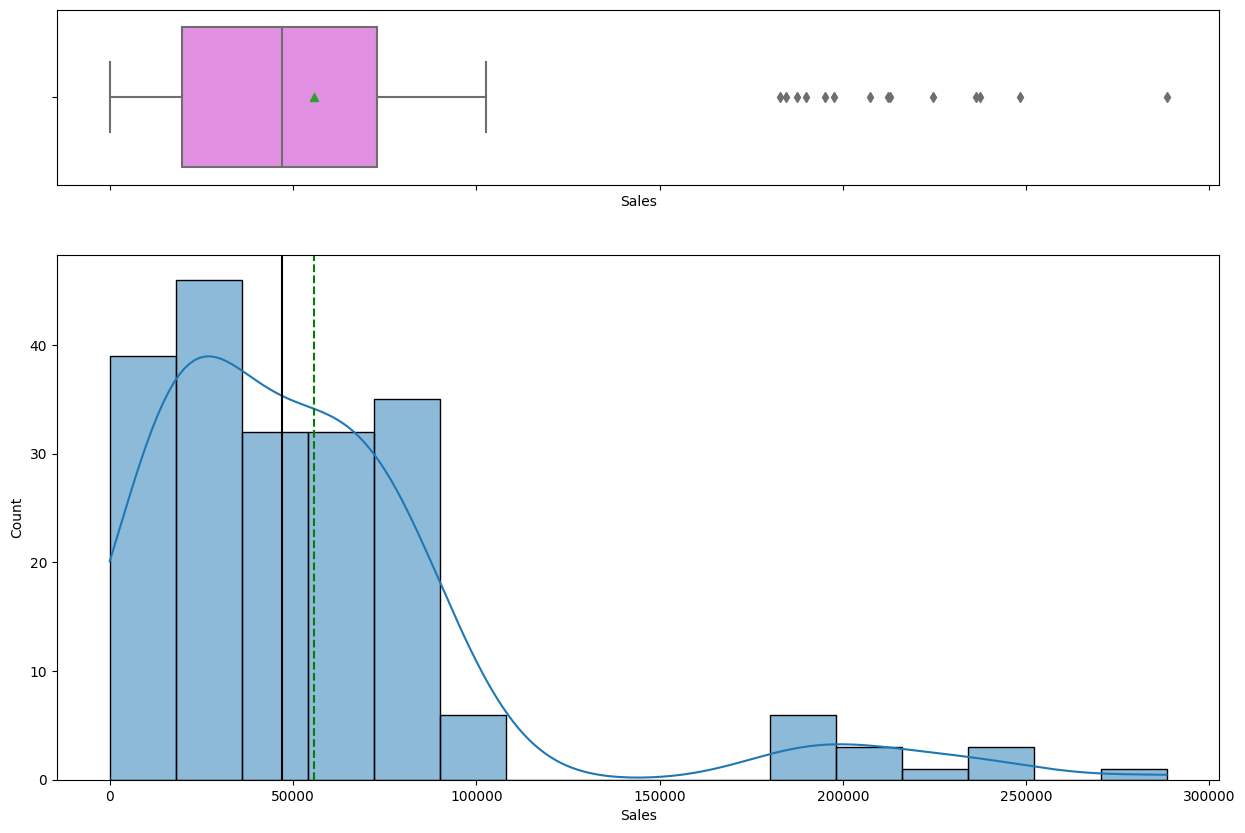

In [ ]:
histplot_boxplot(df3['Sales'])

In [ ]:
df3.describe()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,204.000000,204.0,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,55833.730392,0.0,0.647059,0.318627,0.637255,-2.396471,0.230392,0.019608,0.019608,0.019608
std,50680.310917,0.0,0.479060,0.467090,0.481975,5.811945,0.422120,0.138989,0.138989,0.138989
min,0.000000,0.0,0.000000,0.000000,0.000000,-28.490000,0.000000,0.000000,0.000000,0.000000
25%,19622.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47000.500000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,72944.500000,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,288322.000000,0.0,1.000000,1.000000,1.000000,3.900000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#q_hi  = df1['Sales'].quantile(0.99)
Q1 = np.percentile(df3['Sales'], 25, method='midpoint')
Q3 = np.percentile(df3['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df3 = df3[(df3['Sales'] < upper)]

53491.5


In [ ]:
df3_exclude= df3.iloc[:, 1:]

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


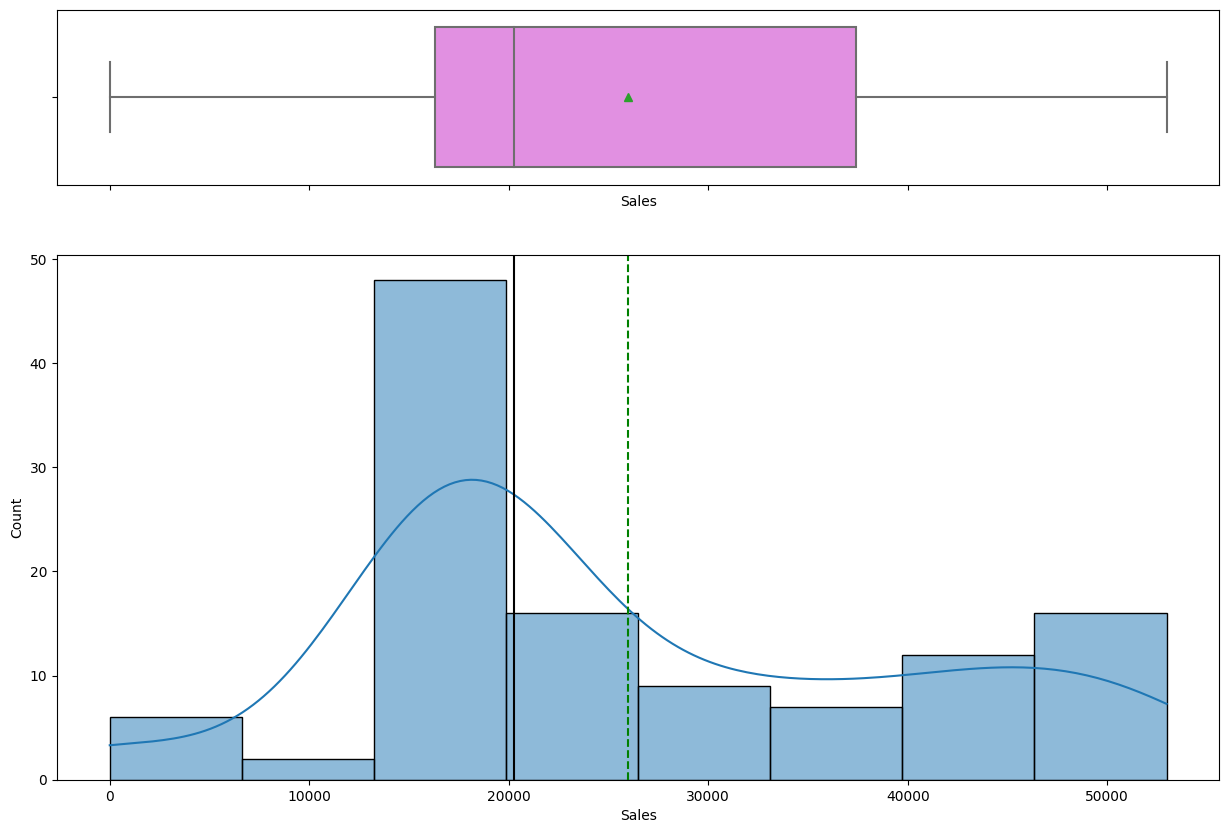

In [ ]:
histplot_boxplot(df3['Sales'])

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


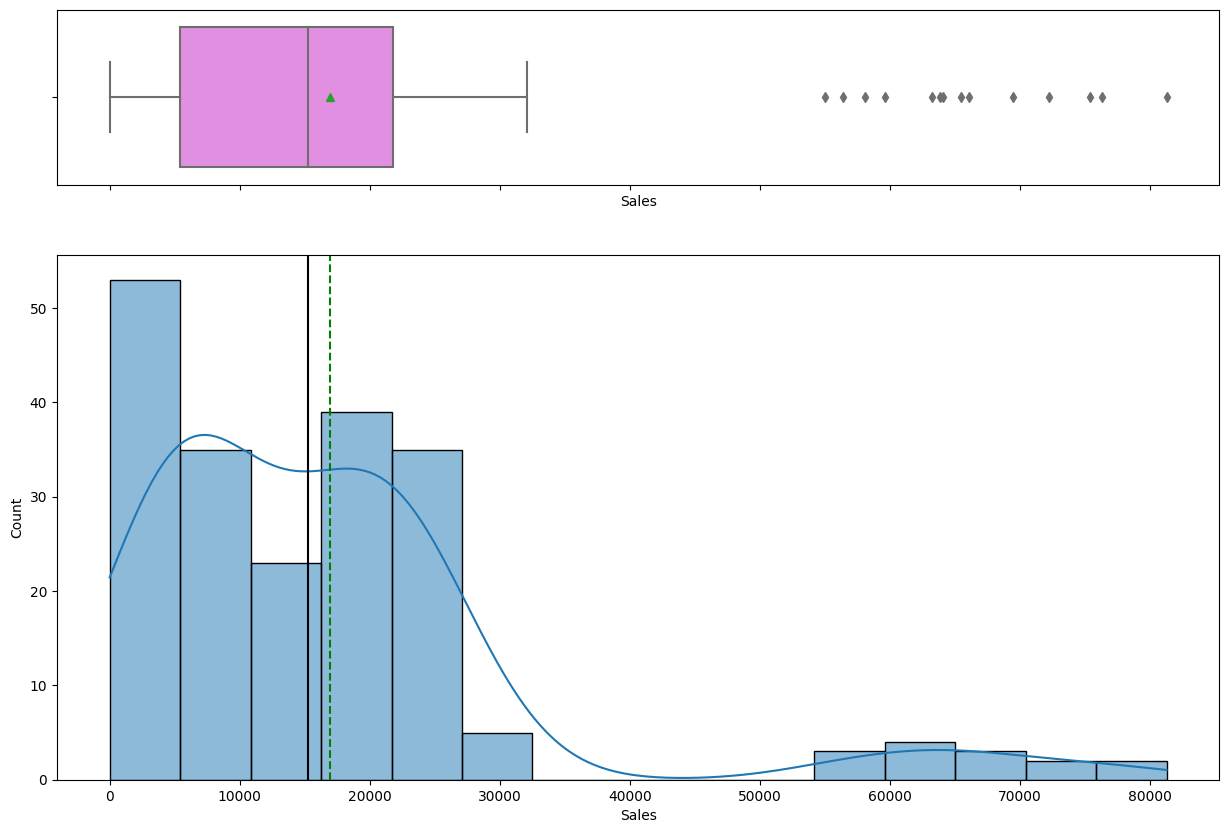

In [ ]:
histplot_boxplot(df4['Sales'])

In [ ]:
df4.describe()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,204.000000,204.0,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,16976.524510,0.0,0.647059,0.318627,0.637255,-2.396471,0.230392,0.019608,0.019608,0.019608
std,15695.224922,0.0,0.479060,0.467090,0.481975,5.811945,0.422120,0.138989,0.138989,0.138989
min,0.000000,0.0,0.000000,0.000000,0.000000,-28.490000,0.000000,0.000000,0.000000,0.000000
25%,5368.750000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15270.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21769.500000,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,81301.000000,0.0,1.000000,1.000000,1.000000,3.900000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#q_hi  = df1['Sales'].quantile(0.99)
Q1 = np.percentile(df4['Sales'], 25, method='midpoint')
Q3 = np.percentile(df4['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df4 = df4[(df4['Sales'] < upper)]

16423.5


In [ ]:
df4_exclude= df4.iloc[:, 1:]

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


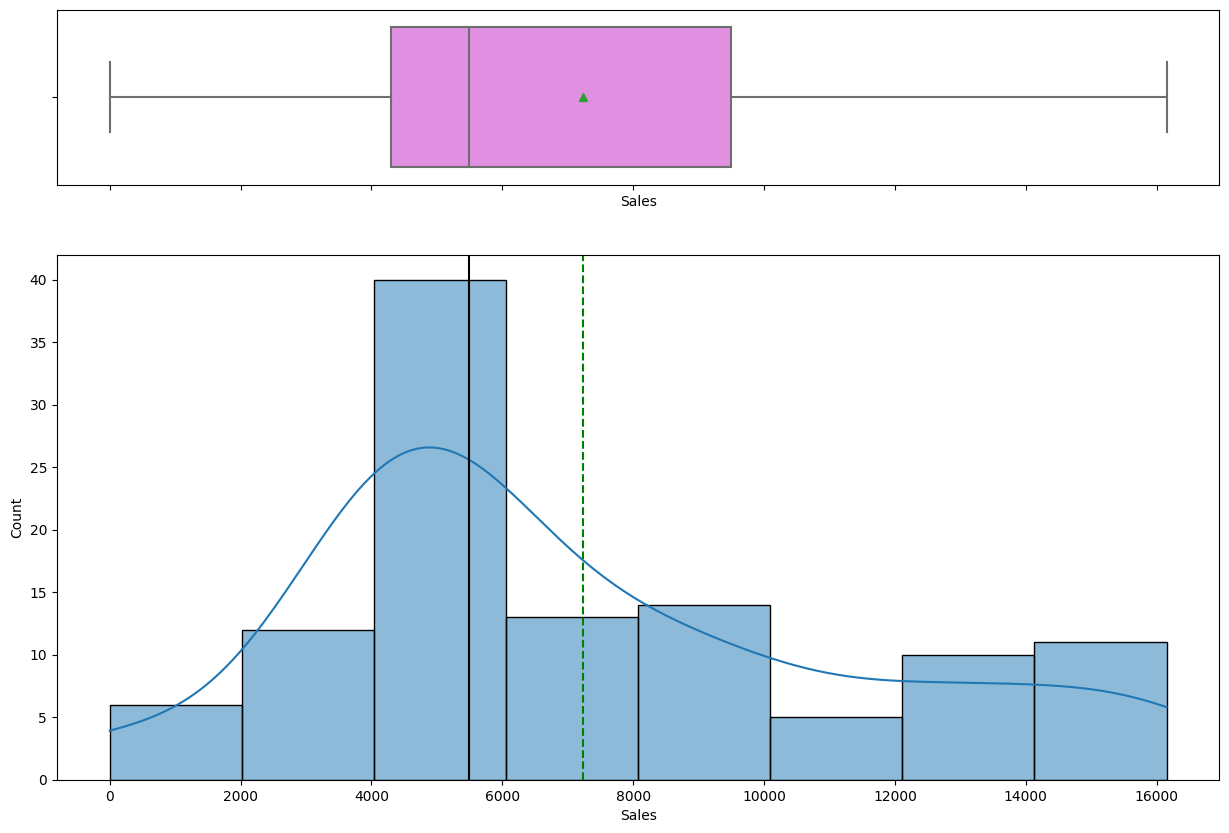

In [ ]:
histplot_boxplot(df4['Sales'])

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


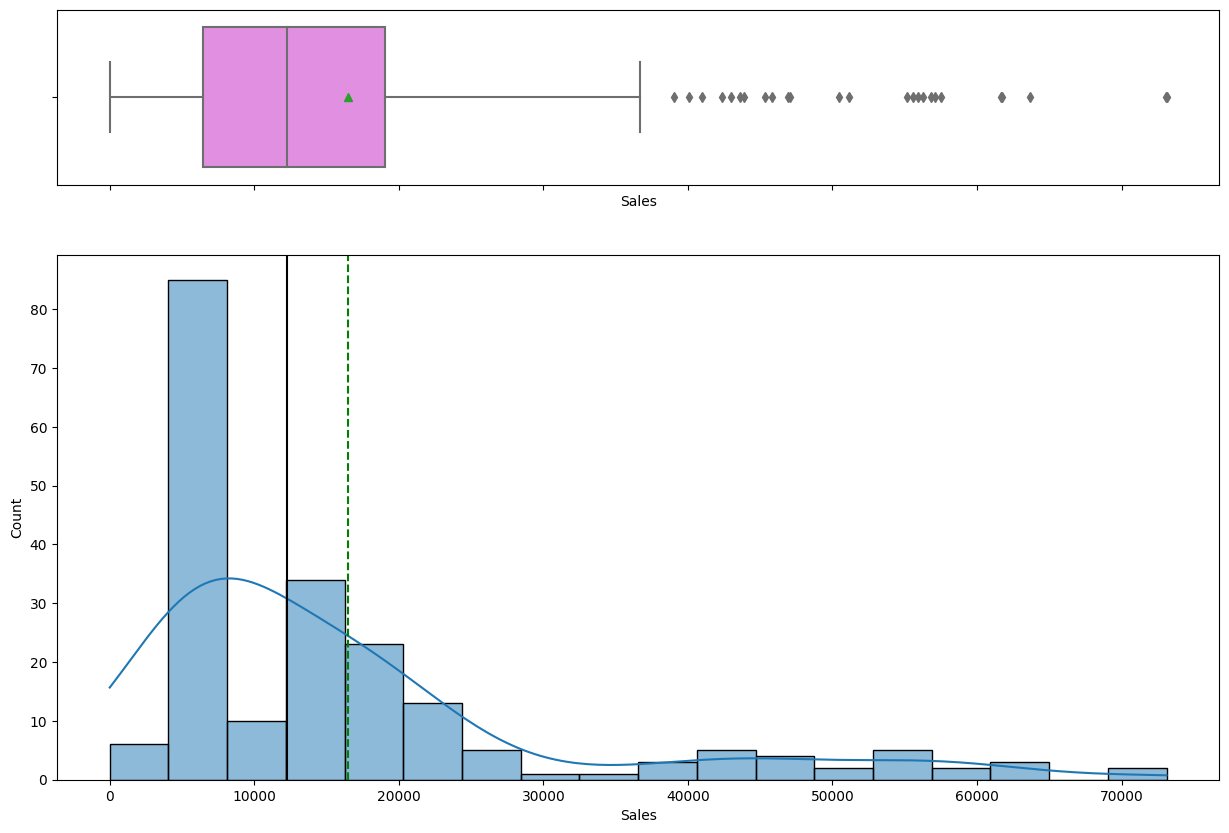

In [ ]:
histplot_boxplot(df5['Sales'])

In [ ]:
df5.describe()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,204.000000,204.0,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,16471.024510,0.0,0.392157,0.171569,0.107843,-2.396471,0.230392,0.019608,0.019608,0.019608
std,15270.790089,0.0,0.489432,0.377933,0.310945,5.811945,0.422120,0.138989,0.138989,0.138989
min,0.000000,0.0,0.000000,0.000000,0.000000,-28.490000,0.000000,0.000000,0.000000,0.000000
25%,6450.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12249.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,19052.500000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,73114.000000,0.0,1.000000,1.000000,1.000000,3.900000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#q_hi  = df1['Sales'].quantile(0.99)
Q1 = np.percentile(df5['Sales'], 25, method='midpoint')
Q3 = np.percentile(df5['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df5 = df5[(df5['Sales'] < upper)]

12673.5


In [ ]:
df5_exclude= df5.iloc[:, 1:]

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


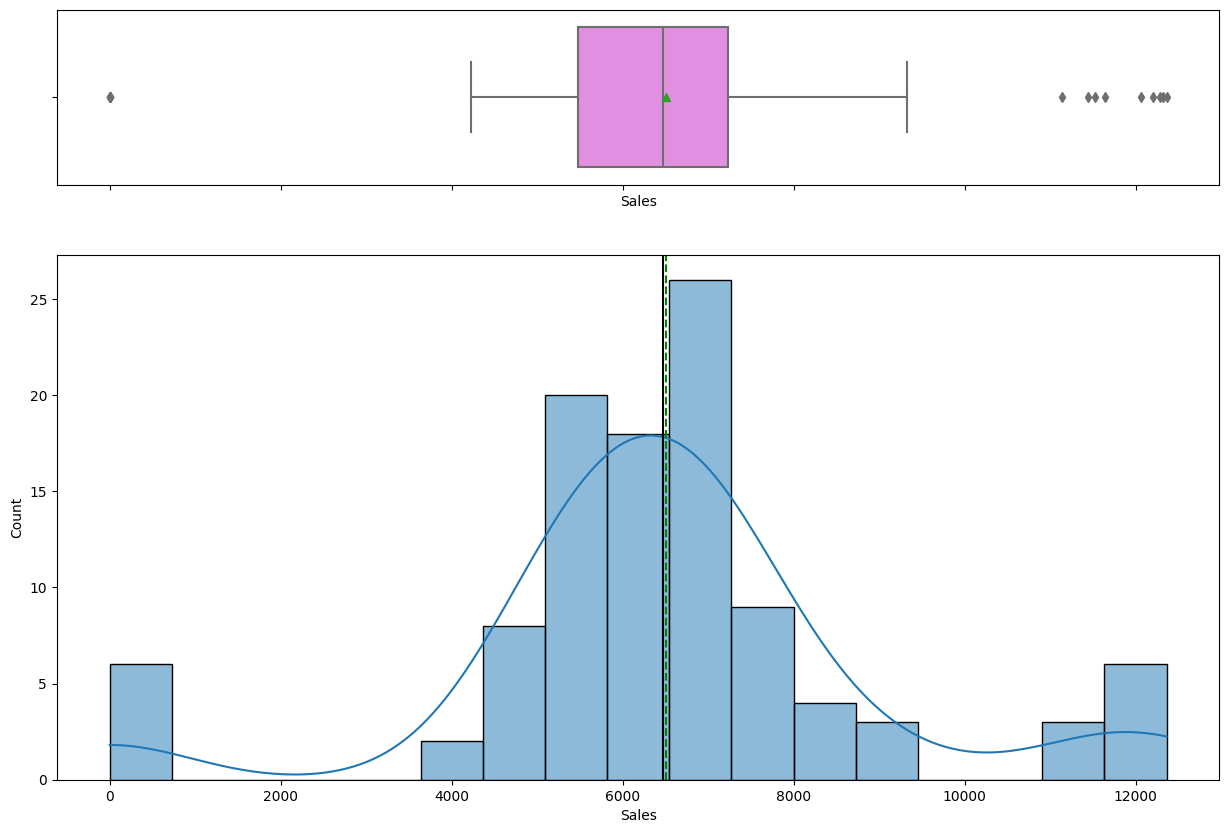

In [ ]:
histplot_boxplot(df5['Sales'])

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


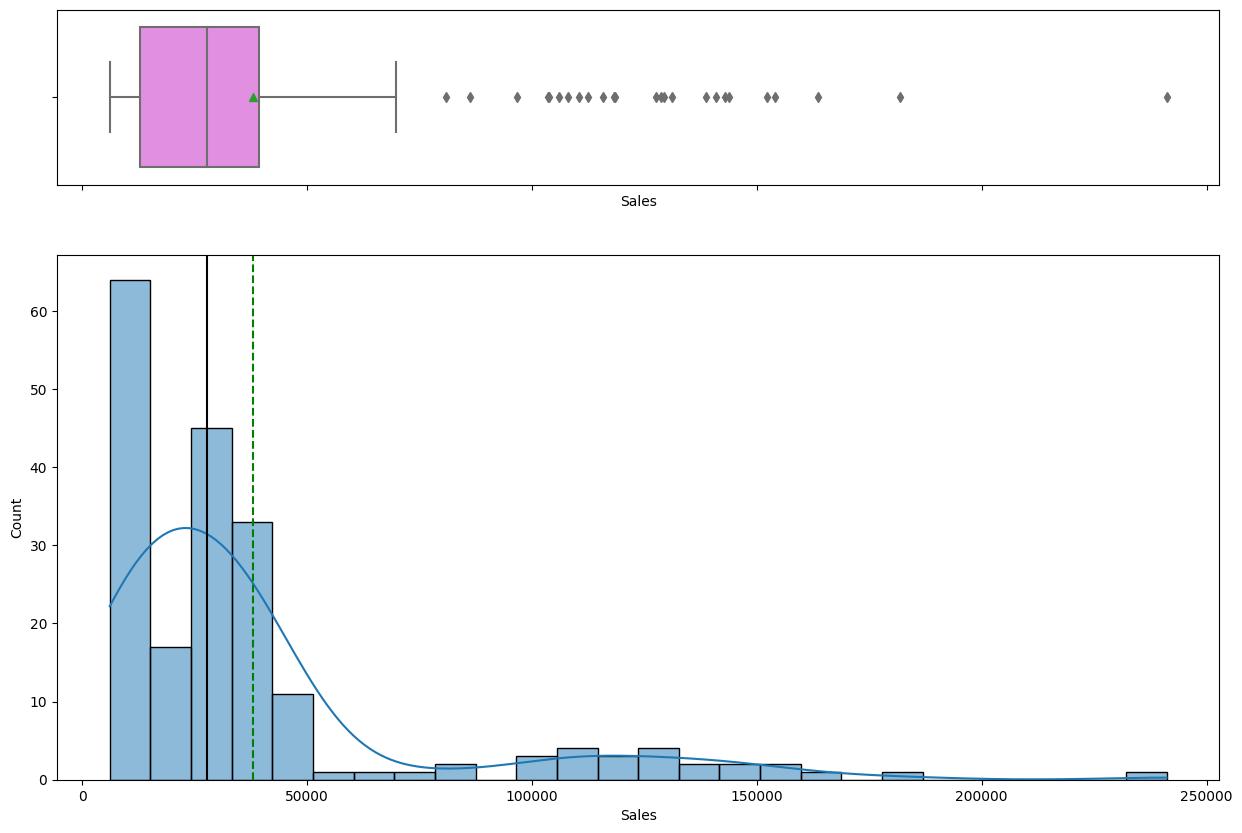

In [ ]:
histplot_boxplot(df6['Sales'])

In [ ]:
df6.describe()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,198.000000,198.0,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,37883.424242,0.0,0.414141,0.252525,0.409091,-2.279192,0.207071,0.020202,0.020202,0.015152
std,38752.334828,0.0,0.493822,0.435562,0.492912,5.849670,0.406234,0.141047,0.141047,0.122465
min,6067.000000,0.0,0.000000,0.000000,0.000000,-28.490000,0.000000,0.000000,0.000000,0.000000
25%,12799.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27613.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,39227.750000,0.0,1.000000,0.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,241114.000000,0.0,1.000000,1.000000,1.000000,3.900000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#q_hi  = df1['Sales'].quantile(0.99)
Q1 = np.percentile(df6['Sales'], 25, method='midpoint')
Q3 = np.percentile(df6['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df6 = df6[(df6['Sales'] < upper)]

26375.0


In [ ]:
df6_exclude= df6.iloc[:, 1:]

<ipython-input-33-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


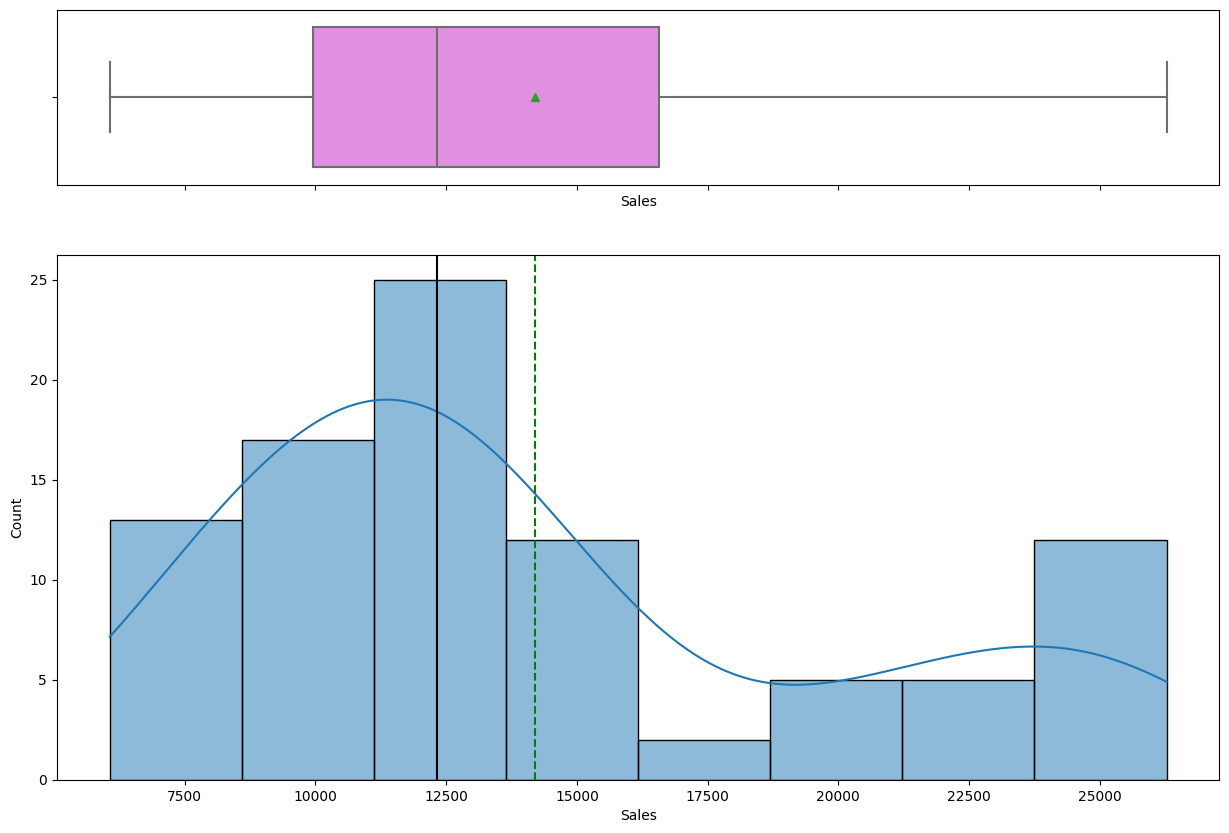

In [ ]:
histplot_boxplot(df6['Sales'])

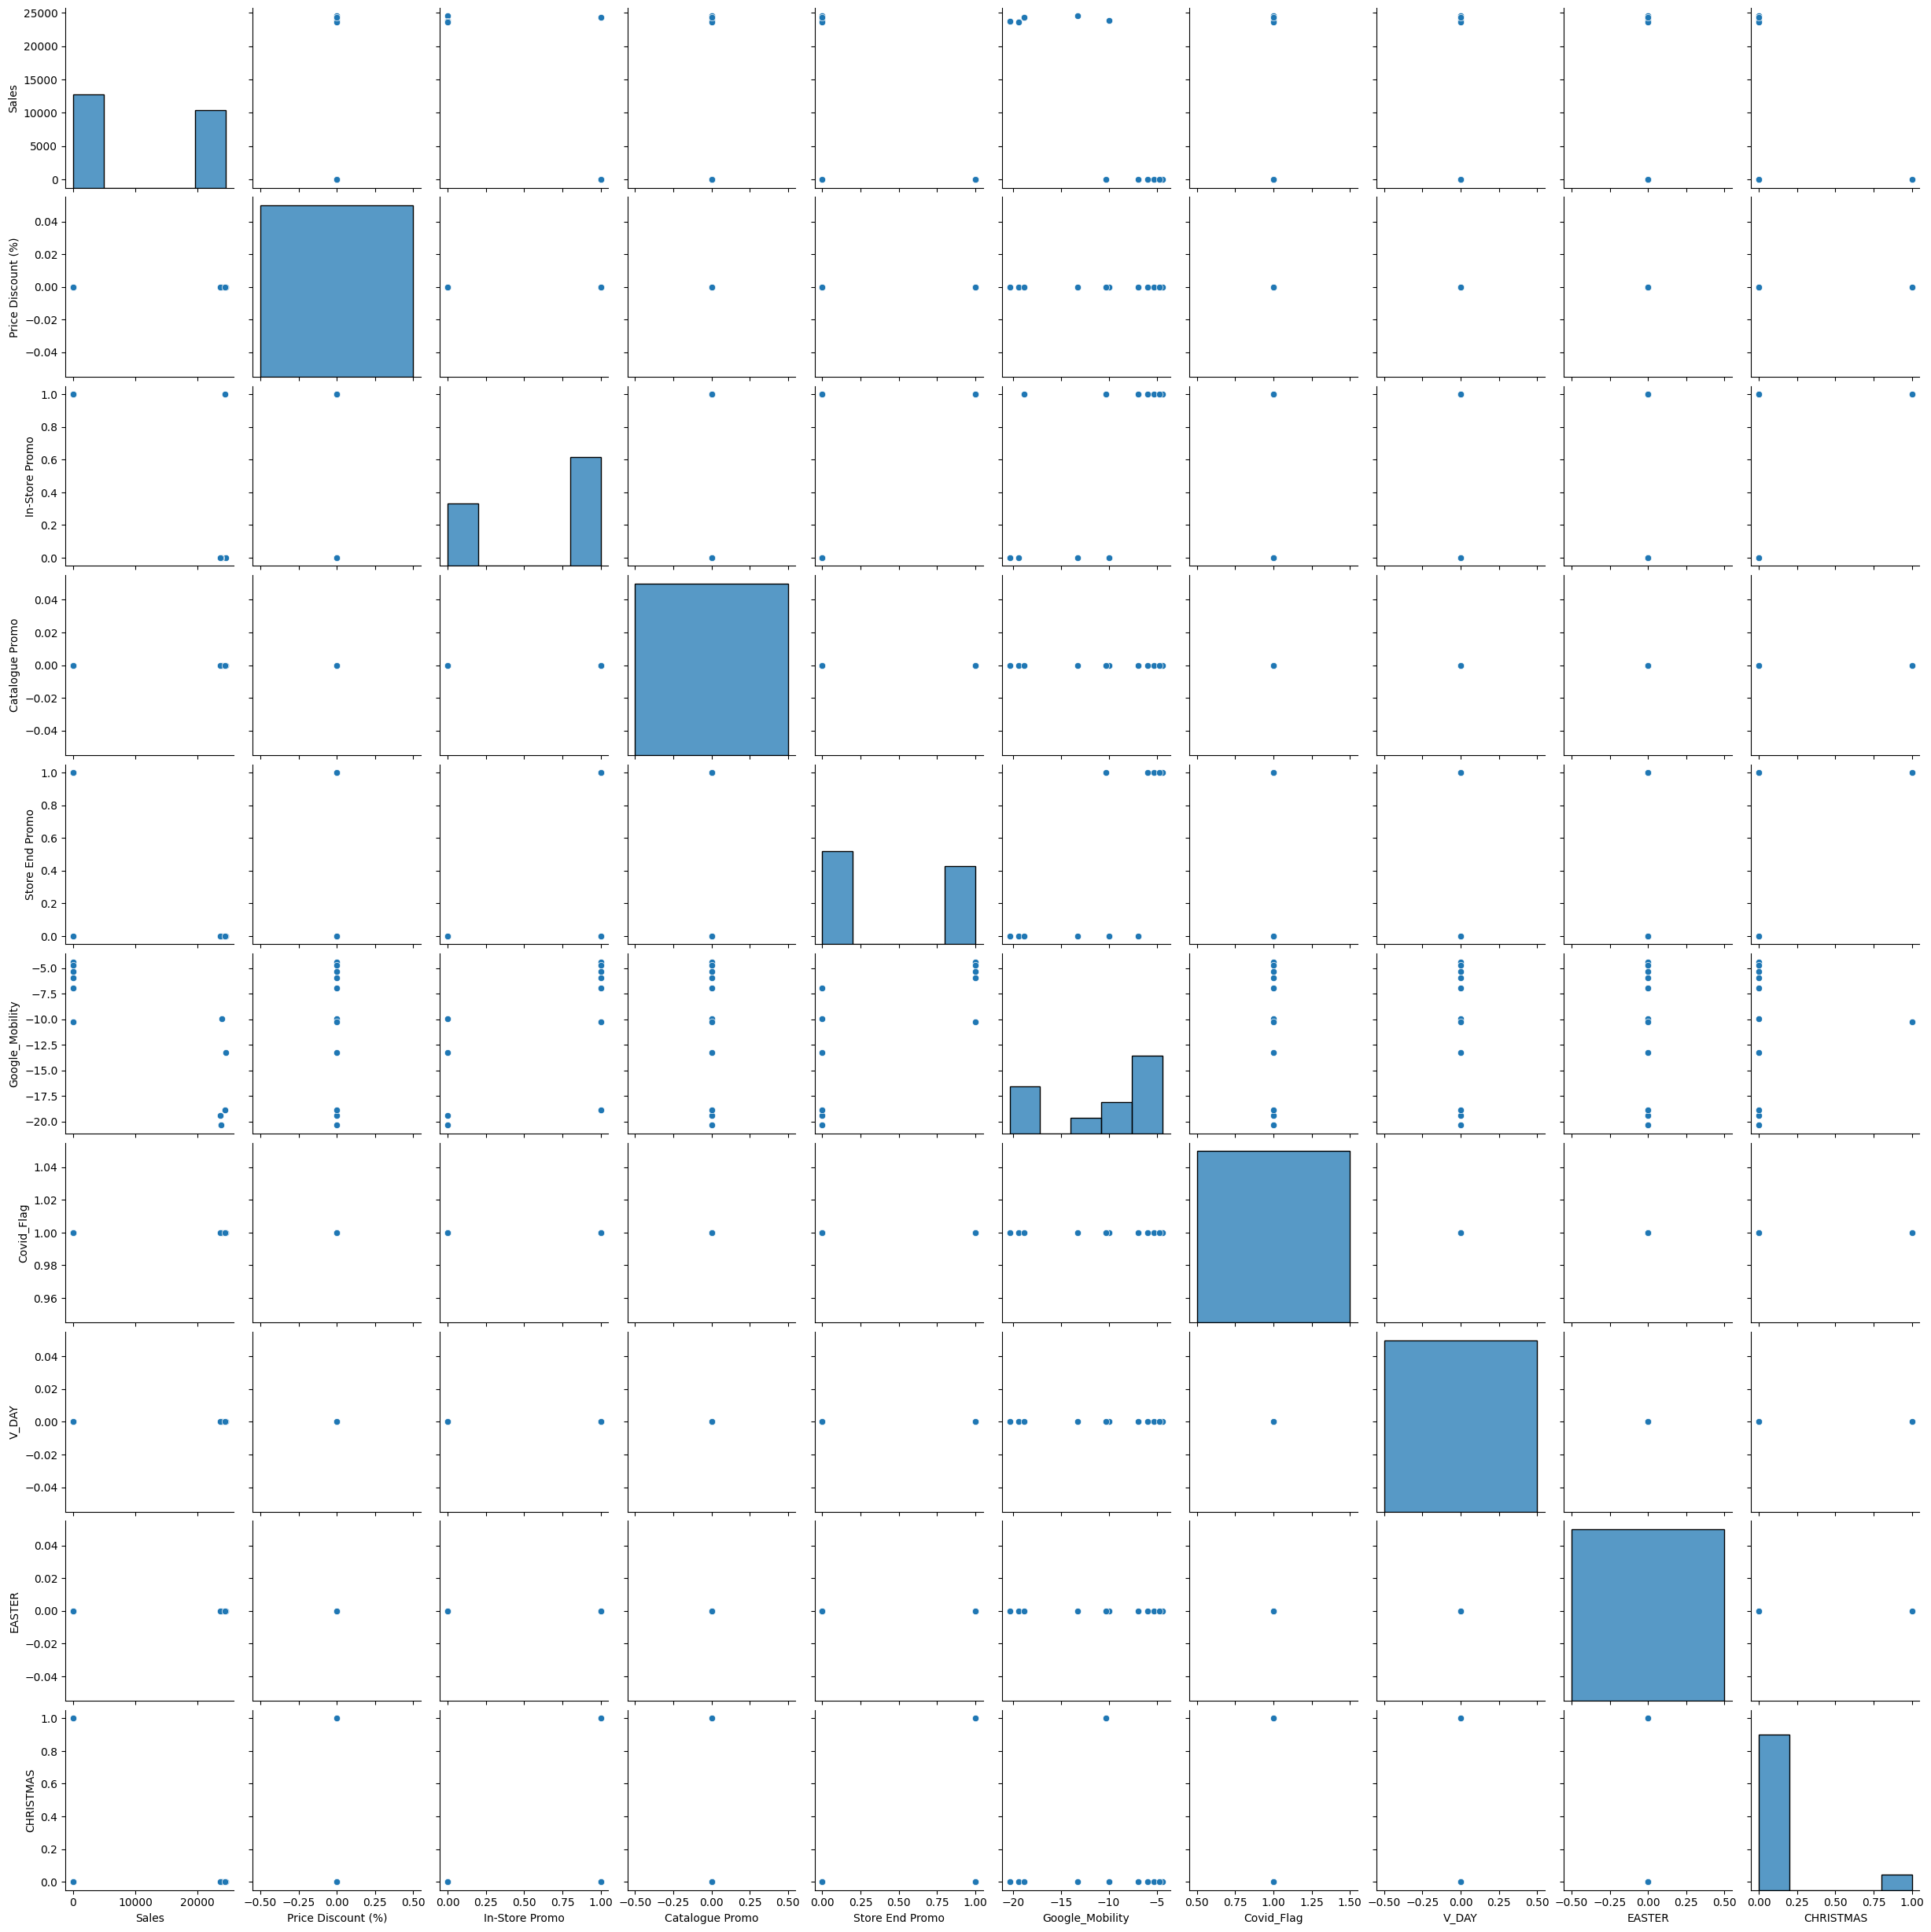

In [ ]:

sns.pairplot(data=df1.iloc[:, 1:])

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     df1test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df1test[0])
     print("2. P-Value : ", df1test[1])
     print("3. Num Of Lags : ", df1test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df1test[3])
     print("5. Critical Values :")
     for key, val in df1test[4].items():
         print("\t",key, ": ", val)
adf_test(df1['Sales'])

1. ADF :  -1.0076188092748983
2. P-Value :  0.7504753824440884
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 10
5. Critical Values :
	 1% :  -4.331573
	 5% :  -3.23295
	 10% :  -2.7487


In [ ]:
df1["Sales"].astype(int)

181    23891
183    24543
184    23744
185    23606
186    24346
198        0
199        0
200        0
201        0
202        0
203        0
Name: Sales, dtype: int64

In [ ]:
df1.head()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
181,2020-07-26,23891,0,0,0,0,-9.93,1,0,0,0
183,2020-08-09,24543,0,0,0,0,-13.23,1,0,0,0
184,2020-08-16,23744,0,0,0,0,-20.35,1,0,0,0
185,2020-08-23,23606,0,0,0,0,-19.41,1,0,0,0
186,2020-08-30,24346,0,1,0,0,-18.83,1,0,0,0


In [ ]:
df1['Sales'] = pd.to_numeric(df1['Sales'])
df1.dtypes

date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [ ]:
el_df=df1.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

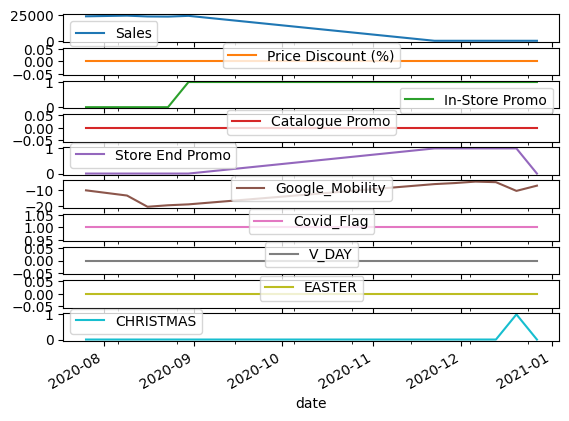

In [ ]:
el_df.plot(subplots=True)

In [ ]:
el_df.resample('M').mean()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
date,,,,,,,,,,
2020-07-31,23891.00,0.0,0.00,0.0,0.00,-9.930,1.0,0.0,0.0,0.00
2020-08-31,24059.75,0.0,0.25,0.0,0.00,-17.955,1.0,0.0,0.0,0.00
2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-30,0.00,0.0,1.00,0.0,1.00,-5.630,1.0,0.0,0.0,0.00
2020-12-31,0.00,0.0,1.00,0.0,0.75,-6.585,1.0,0.0,0.0,0.25


In [ ]:
print ("\nMissing values :  ", df1.isnull().any())


Missing values :   date                  False
Sales                 False
Price Discount (%)    False
In-Store Promo        False
Catalogue Promo       False
Store End Promo       False
Google_Mobility       False
Covid_Flag            False
V_DAY                 False
EASTER                False
CHRISTMAS             False
dtype: bool


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

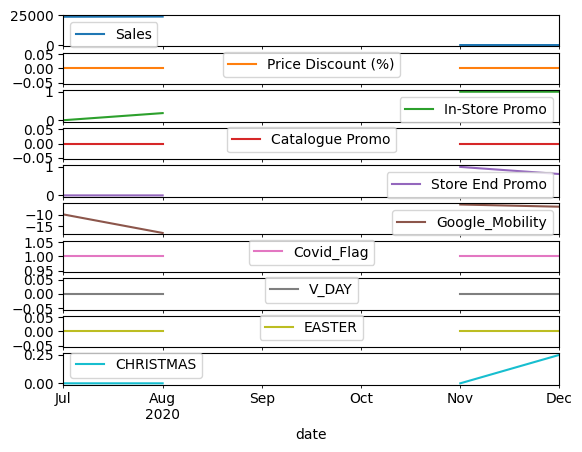

In [ ]:
el_df.resample('M').mean().plot(subplots=True)

In [ ]:
final_df=el_df.resample('M').mean()

In [ ]:
final_df.isnull().any()

Sales                 True
Price Discount (%)    True
In-Store Promo        True
Catalogue Promo       True
Store End Promo       True
Google_Mobility       True
Covid_Flag            True
V_DAY                 True
EASTER                True
CHRISTMAS             True
dtype: bool

In [ ]:
final_df1=final_df.dropna()

final_df1.isna().sum()

Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     df2test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df2test[0])
     print("2. P-Value : ", df2test[1])
     print("3. Num Of Lags : ", df2test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df2test[3])
     print("5. Critical Values :")
     for key, val in df2test[4].items():
         print("\t",key, ": ", val)
adf_test(df2['Sales'])

1. ADF :  -2.4102471662160756
2. P-Value :  0.13886508482595517
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 116
5. Critical Values :
	 1% :  -3.4880216384691867
	 5% :  -2.8867966864160075
	 10% :  -2.5802408234244947


In [ ]:
df2["Sales"].astype(int)

2      2753
3      3062
5      3124
7      3226
9      3084
       ... 
199       0
200       0
201       0
202       0
203       0
Name: Sales, Length: 117, dtype: int64

In [ ]:
df2['Sales'] = pd.to_numeric(df2['Sales'])
df2.dtypes

date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [ ]:
el_df2=df2.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

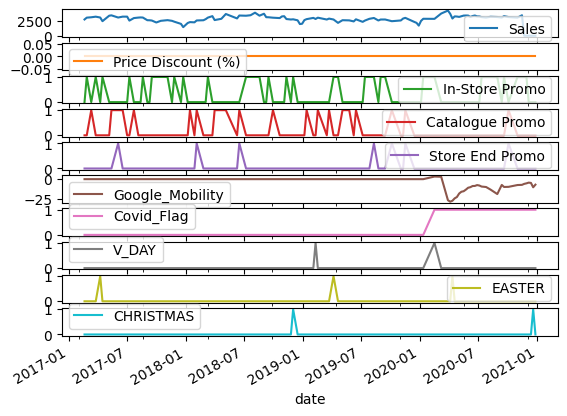

In [ ]:
el_df2.plot(subplots=True)

In [ ]:
el_df2.resample('M').mean()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
date,,,,,,,,,,
2017-02-28,2907.500000,0.0,0.500000,0.000000,0.000000,0.0000,0.0,0.000000,0.00,0.00
2017-03-31,3175.000000,0.0,0.500000,0.500000,0.000000,0.0000,0.0,0.000000,0.00,0.00
2017-04-30,2773.500000,0.0,0.500000,0.000000,0.000000,0.0000,0.0,0.000000,0.50,0.00
2017-05-31,3420.000000,0.0,0.000000,0.500000,0.000000,0.0000,0.0,0.000000,0.00,0.00
2017-06-30,3156.500000,0.0,0.000000,1.000000,0.500000,0.0000,0.0,0.000000,0.00,0.00
2017-07-31,2927.333333,0.0,0.333333,0.333333,0.000000,0.0000,0.0,0.000000,0.00,0.00
2017-08-31,3082.333333,0.0,0.333333,0.000000,0.000000,0.0000,0.0,0.000000,0.00,0.00
2017-09-30,2605.000000,0.0,0.333333,0.000000,0.000000,0.0000,0.0,0.000000,0.00,0.00
2017-10-31,2382.500000,0.0,1.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.00,0.00



Missing values :   date                  False
Sales                 False
Price Discount (%)    False
In-Store Promo        False
Catalogue Promo       False
Store End Promo       False
Google_Mobility       False
Covid_Flag            False
V_DAY                 False
EASTER                False
CHRISTMAS             False
dtype: bool


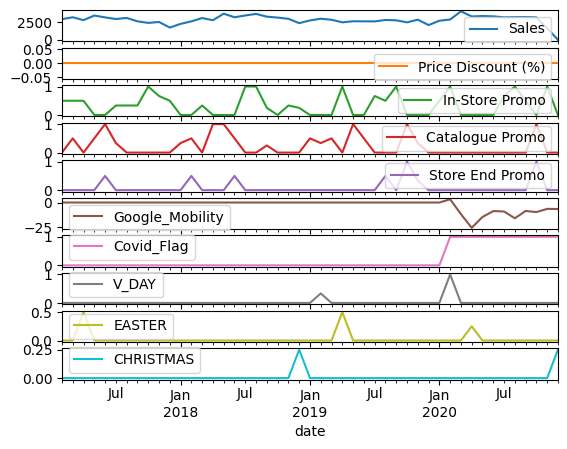

In [ ]:
print ("\nMissing values :  ", df1.isnull().any())

el_df2.resample('M').mean().plot(subplots=True)

final_df2=el_df2.resample('M').mean()

In [ ]:
final_df2.isnull().any()

Sales                 False
Price Discount (%)    False
In-Store Promo        False
Catalogue Promo       False
Store End Promo       False
Google_Mobility       False
Covid_Flag            False
V_DAY                 False
EASTER                False
CHRISTMAS             False
dtype: bool

In [ ]:
final_df2=final_df2.dropna()

final_df2.isna().sum()

Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

In [ ]:
def adf_test(dataset):
     df3test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df3test[0])
     print("2. P-Value : ", df3test[1])
     print("3. Num Of Lags : ", df3test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df3test[3])
     print("5. Critical Values :")
     for key, val in df3test[4].items():
         print("\t",key, ": ", val)
adf_test(df3['Sales'])

1. ADF :  -2.732775025967565
2. P-Value :  0.06853643571804792
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression: 110
5. Critical Values :
	 1% :  -3.4912451337340342
	 5% :  -2.8881954545454547
	 10% :  -2.5809876033057852


In [ ]:
df3["Sales"].astype(int)

0      39767
1      49090
2      41044
4      13568
5      48230
       ...  
199        0
200        0
201        0
202        0
203        0
Name: Sales, Length: 116, dtype: int64

In [ ]:
df3['Sales'] = pd.to_numeric(df3['Sales'])
df3.dtypes


date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [ ]:
el_df3=df3.set_index('date')


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

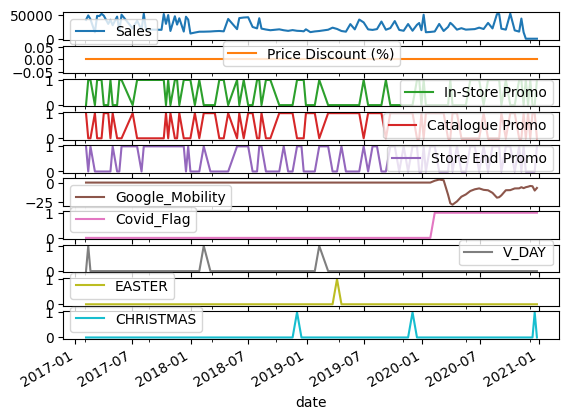

In [ ]:
el_df3.plot(subplots=True)


In [ ]:
el_df3.resample('M').mean()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
date,,,,,,,,,,
2017-02-28,43300.333333,0.0,0.666667,0.333333,0.666667,0.000000,0.0,0.333333,0.0,0.00
2017-03-31,40472.000000,0.0,0.750000,0.250000,0.000000,0.000000,0.0,0.000000,0.0,0.00
2017-04-30,37060.250000,0.0,0.250000,0.750000,0.250000,0.000000,0.0,0.000000,0.0,0.00
2017-05-31,37688.333333,0.0,0.666667,0.000000,0.333333,0.000000,0.0,0.000000,0.0,0.00
2017-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-31,26180.666667,0.0,0.666667,0.333333,0.666667,0.000000,0.0,0.000000,0.0,0.00
2017-08-31,36116.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.00
2017-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-31,33686.600000,0.0,0.600000,0.400000,1.000000,0.000000,0.0,0.000000,0.0,0.00



Missing values :   date                  False
Sales                 False
Price Discount (%)    False
In-Store Promo        False
Catalogue Promo       False
Store End Promo       False
Google_Mobility       False
Covid_Flag            False
V_DAY                 False
EASTER                False
CHRISTMAS             False
dtype: bool


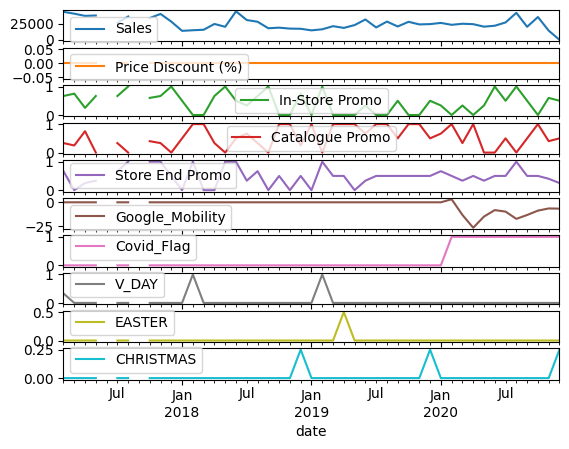

In [ ]:
print ("\nMissing values :  ", df3.isnull().any())

el_df3.resample('M').mean().plot(subplots=True)

final_df3=el_df.resample('M').mean()

In [ ]:
final_df3.isnull().any()

Sales                 True
Price Discount (%)    True
In-Store Promo        True
Catalogue Promo       True
Store End Promo       True
Google_Mobility       True
Covid_Flag            True
V_DAY                 True
EASTER                True
CHRISTMAS             True
dtype: bool

In [ ]:
final_df3=final_df3.dropna()

final_df3.isna().sum()

Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

In [ ]:
def adf_test(dataset):
     df4test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df4test[0])
     print("2. P-Value : ", df4test[1])
     print("3. Num Of Lags : ", df4test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df4test[3])
     print("5. Critical Values :")
     for key, val in df4test[4].items():
         print("\t",key, ": ", val)
adf_test(df4['Sales'])

1. ADF :  -2.9267011767455893
2. P-Value :  0.0423299564919738
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression: 108
5. Critical Values :
	 1% :  -3.4924012594942333
	 5% :  -2.8886968193364835
	 10% :  -2.5812552709190673


In [ ]:
df4["Sales"].astype(int)

0      12835
1      15705
2      13382
3      15709
4       3729
       ...  
199        0
200        0
201        0
202        0
203        0
Name: Sales, Length: 111, dtype: int64

In [ ]:
df4['Sales'] = pd.to_numeric(df4['Sales'])
df4.dtypes

date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [ ]:
el_df4=df4.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

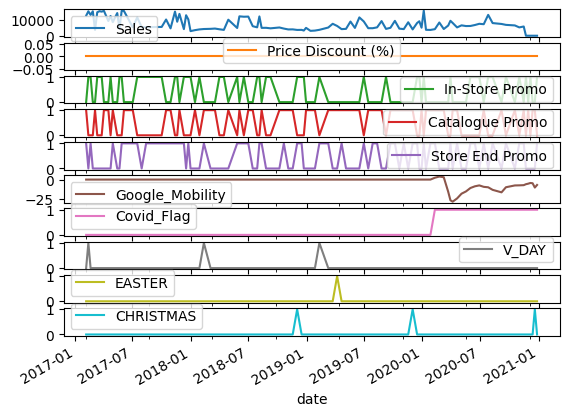

In [ ]:
el_df4.plot(subplots=True)

In [ ]:
el_df4.resample('M').mean()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
date,,,,,,,,,,
2017-02-28,14407.750000,0.0,0.500000,0.250000,0.500000,0.000000,0.0,0.25,0.0,0.00
2017-03-31,12507.000000,0.0,0.750000,0.250000,0.000000,0.000000,0.0,0.00,0.0,0.00
2017-04-30,11720.000000,0.0,0.250000,0.750000,0.250000,0.000000,0.0,0.00,0.0,0.00
2017-05-31,11654.333333,0.0,0.666667,0.000000,0.333333,0.000000,0.0,0.00,0.0,0.00
2017-06-30,15932.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.0,0.00,0.0,0.00
2017-07-31,7573.333333,0.0,0.666667,0.333333,0.666667,0.000000,0.0,0.00,0.0,0.00
2017-08-31,5497.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.0,0.00,0.0,0.00
2017-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-31,6928.333333,0.0,0.333333,0.666667,1.000000,0.000000,0.0,0.00,0.0,0.00



Missing values :   date                  False
Sales                 False
Price Discount (%)    False
In-Store Promo        False
Catalogue Promo       False
Store End Promo       False
Google_Mobility       False
Covid_Flag            False
V_DAY                 False
EASTER                False
CHRISTMAS             False
dtype: bool


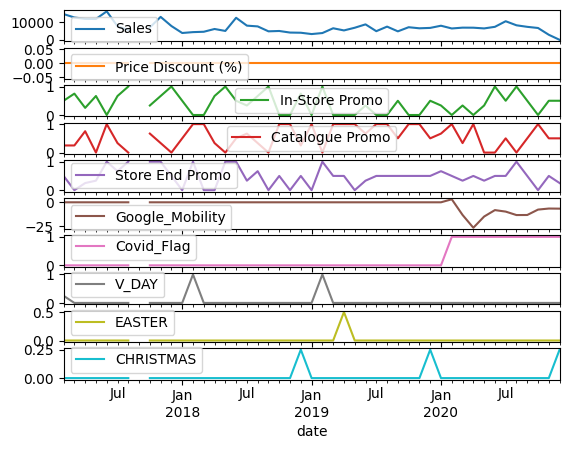

In [ ]:
print ("\nMissing values :  ", df4.isnull().any())

el_df4.resample('M').mean().plot(subplots=True)

final_df4=el_df4.resample('M').mean()

In [ ]:
final_df4.isnull().any()

Sales                 True
Price Discount (%)    True
In-Store Promo        True
Catalogue Promo       True
Store End Promo       True
Google_Mobility       True
Covid_Flag            True
V_DAY                 True
EASTER                True
CHRISTMAS             True
dtype: bool

In [ ]:
final_df4=final_df4.dropna()

final_df4.isna().sum()

Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

In [ ]:
def adf_test(dataset):
     df5test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df5test[0])
     print("2. P-Value : ", df5test[1])
     print("3. Num Of Lags : ", df5test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df5test[3])
     print("5. Critical Values :")
     for key, val in df5test[4].items():
         print("\t",key, ": ", val)
adf_test(df5['Sales'])

1. ADF :  -5.223830770998545
2. P-Value :  7.858760353568244e-06
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 104
5. Critical Values :
	 1% :  -3.4948504603223145
	 5% :  -2.889758398668639
	 10% :  -2.5818220155325444


In [ ]:
df5["Sales"].astype(int)

0      5229
1      5748
3      5928
5      5952
6      5994
       ... 
199       0
200       0
201       0
202       0
203       0
Name: Sales, Length: 105, dtype: int64

In [ ]:
df5['Sales'] = pd.to_numeric(df5['Sales'])
df5.dtypes

date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [ ]:
el_df5=df5.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

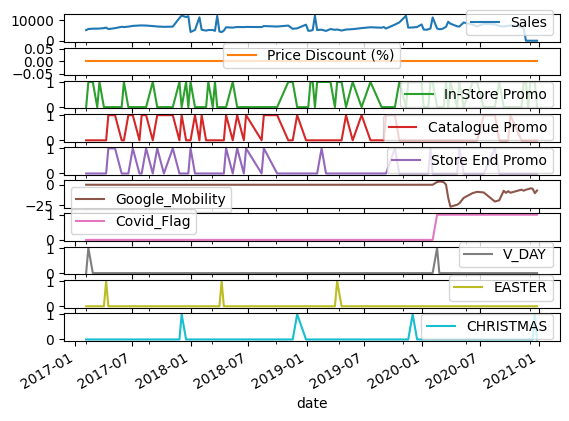

In [ ]:
el_df5.plot(subplots=True)

In [ ]:
el_df5.resample('M').mean()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
date,,,,,,,,,,
2017-02-28,5635.000000,0.0,0.666667,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
2017-03-31,5973.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-04-30,6133.666667,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000
2017-05-31,6515.000000,0.0,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-06-30,6821.500000,0.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07-31,7429.666667,0.0,0.000000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
2017-08-31,7462.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-09-30,7104.500000,0.0,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-10-31,6830.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Missing values :   date                  False
Sales                 False
Price Discount (%)    False
In-Store Promo        False
Catalogue Promo       False
Store End Promo       False
Google_Mobility       False
Covid_Flag            False
V_DAY                 False
EASTER                False
CHRISTMAS             False
dtype: bool


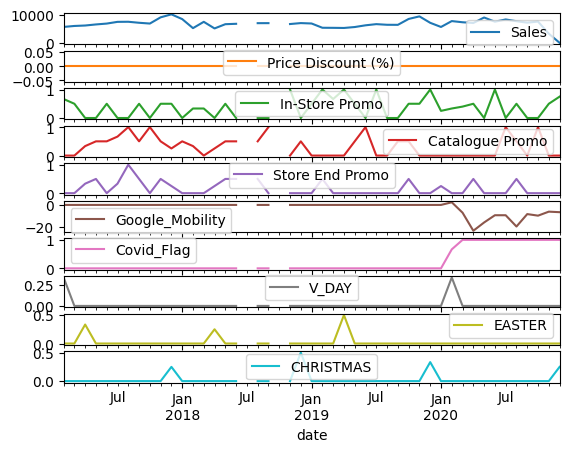

In [ ]:
print ("\nMissing values :  ", df5.isnull().any())

el_df5.resample('M').mean().plot(subplots=True)

final_df5=el_df5.resample('M').mean()

In [ ]:
final_df5.isnull().any()

Sales                 True
Price Discount (%)    True
In-Store Promo        True
Catalogue Promo       True
Store End Promo       True
Google_Mobility       True
Covid_Flag            True
V_DAY                 True
EASTER                True
CHRISTMAS             True
dtype: bool

In [ ]:
final_df5=final_df5.dropna()

final_df5.isna().sum()

Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

In [ ]:
def adf_test(dataset):
     df6test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df6test[0])
     print("2. P-Value : ", df6test[1])
     print("3. Num Of Lags : ", df6test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df6test[3])
     print("5. Critical Values :")
     for key, val in df6test[4].items():
         print("\t",key, ": ", val)
adf_test(df6['Sales'])


1. ADF :  -6.653635162590968
2. P-Value :  5.047724912606583e-09
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression: 88
5. Critical Values :
	 1% :  -3.506944401824286
	 5% :  -2.894989819214876
	 10% :  -2.584614550619835


In [ ]:
df6["Sales"].astype(int)

1      11659
2      12140
4      11666
8      11595
10      9508
       ...  
185    16009
186     8158
188     8164
190    21692
191    23072
Name: Sales, Length: 91, dtype: int64

In [ ]:
df6['Sales'] = pd.to_numeric(df6['Sales'])
df6.dtypes

date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [ ]:
el_df6=df6.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

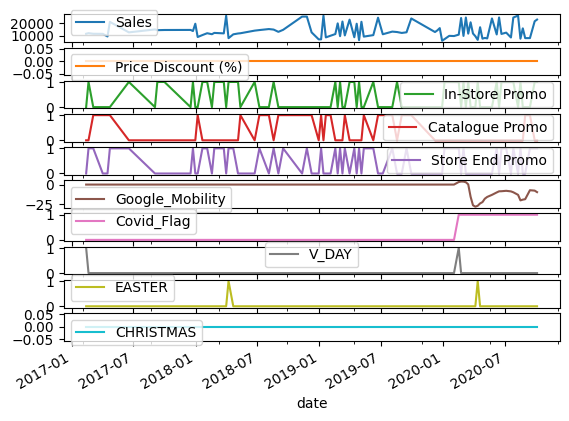

In [ ]:
el_df6.plot(subplots=True)

In [ ]:
el_df6.resample('M').mean()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
date,,,,,,,,,,
2017-02-28,11899.500000,0.0,0.500000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.0
2017-03-31,11666.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
2017-04-30,14102.000000,0.0,0.000000,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0
2017-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-30,12779.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
2017-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-30,14837.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2017-10-31,14692.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0



Missing values :   date                  False
Sales                 False
Price Discount (%)    False
In-Store Promo        False
Catalogue Promo       False
Store End Promo       False
Google_Mobility       False
Covid_Flag            False
V_DAY                 False
EASTER                False
CHRISTMAS             False
dtype: bool


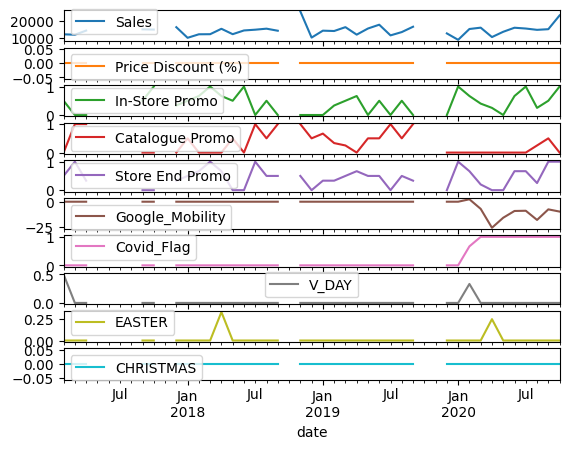

In [ ]:
print ("\nMissing values :  ", df6.isnull().any())

el_df6.resample('M').mean().plot(subplots=True)

final_df6=el_df6.resample('M').mean()

In [ ]:
final_df6.isnull().any()

Sales                 True
Price Discount (%)    True
In-Store Promo        True
Catalogue Promo       True
Store End Promo       True
Google_Mobility       True
Covid_Flag            True
V_DAY                 True
EASTER                True
CHRISTMAS             True
dtype: bool

In [ ]:
final_df6=final_df6.dropna()

final_df6.isna().sum()

Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

In [ ]:
window_spec = Window.orderBy("date")
df = df.withColumn("prev_flag", F.lag("Covid_Flag").over(window_spec))

start_dates = df.filter((F.col("Covid_Flag") == 1) & (F.col("prev_flag") == 0))

start_dates.select("Date").show()

+----------+
|      Date|
+----------+
|2020-02-09|
+----------+



**Observation**  
Covid Flag started from February 09, 2020.  

In [ ]:
! pip install plotly

In [ ]:
import plotly.express as px

pandas_df = df.toPandas()

fig = px.line(pandas_df, x='date', y='Google_Mobility', title='Google_Mobility')

min_desired_value = 0
max_desired_value = 100
fig.update_yaxes(range=[min_desired_value, max_desired_value])

fig.show()

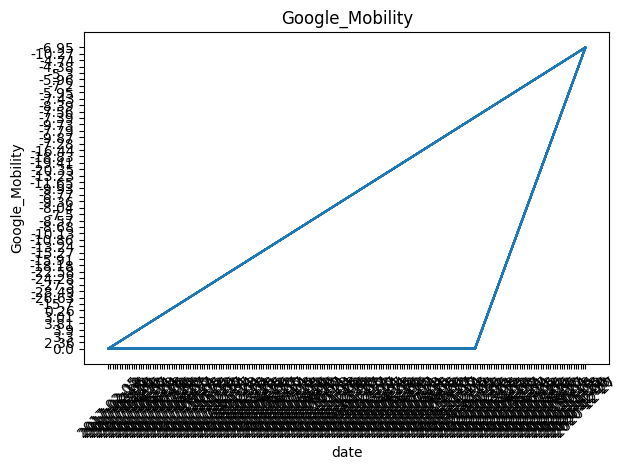

In [ ]:
pandas_df = df.select('date', 'Google_Mobility').toPandas()

plt.figure()
plt.plot(pandas_df['date'], pandas_df['Google_Mobility'])
plt.xlabel('date')
plt.ylabel('Google_Mobility')
plt.title('Google_Mobility')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation**  
-Google Mobility is realted Covid19. This is because the line is flat until February 2, 2020 above the plot. The flat line means there are no activities and no exisiting record.   
-After February 9, 2020, it started fluctuating and keep changing. According to the variable Covid Flag, it started recorded as 1 after February 9, 2020. The timing between Google Mobility and Covid Flag is exactly coinside.  
-Google Mobility data tracks travel patterns in detail, such as how often people go to public places and how much time they spend commuting or shopping. This will allow us to assess the risk of spread of infection and predict the spread of infection in a particular region or city.  

**To analyze the data pre-Covid and post-Covid, we divide the data to 2.**

In [ ]:
before_date = df.filter(col("date") < "2020-02-09")

after_date = df.filter(col("date") >= "2020-02-09")

before_date.show()
after_date.show()

+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+---------+
|Product|      date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|prev_flag|
+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+---------+
|   SKU1|2017-02-05|27750|               0.0|             0|              0|              0|            0.0|         0|    0|     0|        0|     null|
|   SKU2|2017-02-05| 7180|              0.25|             1|              0|              0|            0.0|         0|    0|     0|        0|        0|
|   SKU3|2017-02-05|39767|               0.3|             0|              1|              1|            0.0|         0|    0|     0|        0|        0|
|   SKU4|2017-02-05|12835|               0.3|             0|              1|      

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

before_date = before_date.withColumn('Sales', col('Sales').cast(FloatType()))

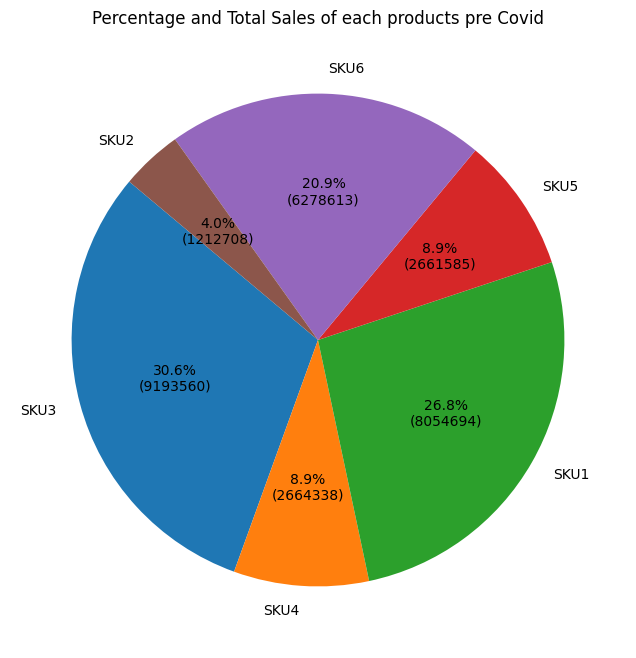

In [ ]:
from pyspark.sql import functions as F

before_date = before_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales = before_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products pre Covid')

plt.show()

In [ ]:
from pyspark.sql.functions import col

null_columns = [col(c).alias(c) for c in after_date.columns]

after_date.select(null_columns).filter(after_date['Sales'].isNull()).show()

+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+---------+
|Product|date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|prev_flag|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+---------+
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+---------+



In [ ]:
after_date1 = after_date.toPandas()
after_date1.isnull().any()

Product               False
date                  False
Sales                 False
Price Discount (%)    False
In-Store Promo        False
Catalogue Promo       False
Store End Promo       False
Google_Mobility       False
Covid_Flag            False
V_DAY                 False
EASTER                False
CHRISTMAS             False
prev_flag             False
dtype: bool

In [ ]:
print(after_date1[after_date1['Sales'].isnull()])

Empty DataFrame
Columns: [Product, date, Sales, Price Discount (%), In-Store Promo, Catalogue Promo, Store End Promo, Google_Mobility, Covid_Flag, V_DAY, EASTER, CHRISTMAS, prev_flag]
Index: []


In [ ]:
after_date = after_date[after_date['Sales'] != 0]

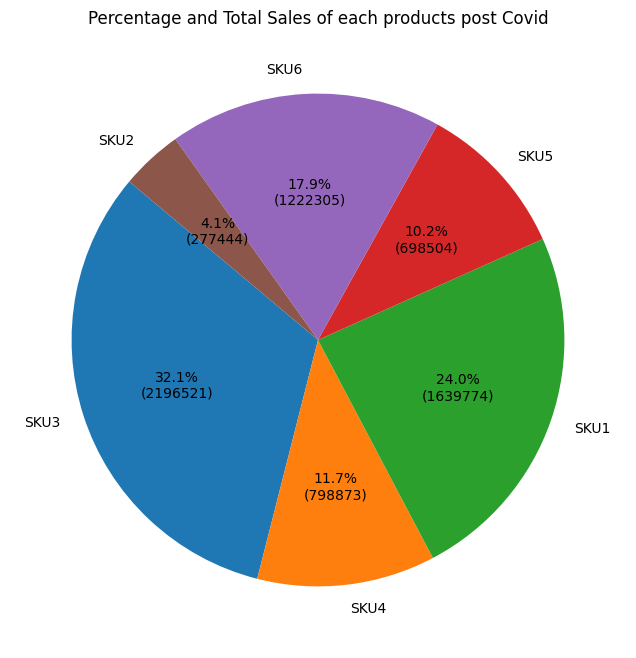

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

after_date = after_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales2 = after_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales2.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products post Covid')

plt.show()


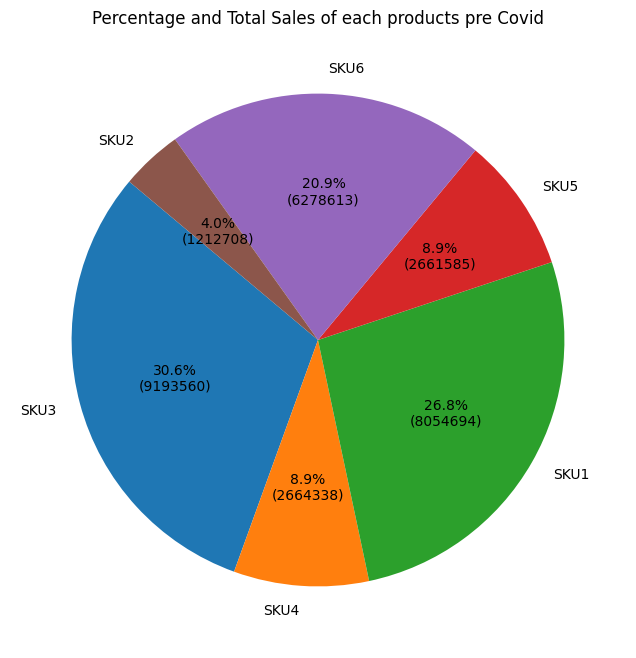

In [ ]:
from pyspark.sql import functions as F

before_date = before_date.withColumn('Sales', F.when(F.col('Sales').isNull(), 0).otherwise(F.col('Sales')))

product_sales = before_date.groupBy('Product').agg(F.sum('Sales').alias('TotalSales'))

product_sales_pd = product_sales.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(product_sales_pd['TotalSales'], labels=product_sales_pd['Product'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(product_sales_pd['TotalSales']) / 100), startangle=140)

plt.title('Percentage and Total Sales of each products pre Covid')

plt.show()

**Observation**  
In terms of the percantages of the products to sales, there are no very big difference between pre covid and post covid.  
In general both before Covid and after Covid, SKU3 is the most popular products. SKU1 is the secondest popular. And SKU6 is the 3rd.   
SKU4 and SKU5 are kinds of same sales amounts. And SKU2 is the least popular products.  

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum

spark = SparkSession.builder.appName("SalesComparison").getOrCreate()

before_covid_sales = before_date.groupBy("Product").agg(sum("Sales").alias("Sales_before_covid"))
after_covid_sales = after_date.groupBy("Product").agg(sum("Sales").alias("Sales_after_covid"))

sales_comparison_table = before_covid_sales.join(after_covid_sales, "Product", "outer")

sales_comparison_table = sales_comparison_table.withColumn("Sales_change", ((col("Sales_after_covid") - col("Sales_before_covid")) / col("Sales_before_covid")) * 100)

sales_comparison_table.show()

+-------+------------------+-----------------+------------------+
|Product|Sales_before_covid|Sales_after_covid|      Sales_change|
+-------+------------------+-----------------+------------------+
|   SKU1|         8054694.0|        1639774.0| -79.6420075051889|
|   SKU2|         1212708.0|         277444.0|-77.12194526629659|
|   SKU3|         9193560.0|        2196521.0|-76.10804737229104|
|   SKU4|         2664338.0|         798873.0|-70.01607904102258|
|   SKU5|         2661585.0|         698504.0|-73.75608894699963|
|   SKU6|         6278613.0|        1222305.0| -80.5322449400847|
+-------+------------------+-----------------+------------------+



**Observation**  
Sales of all of products significantly reduced between 70% and 80% minus after Covid compared to before Covid.  

In [ ]:
from pyspark.sql.types import IntegerType

df = df.withColumn("Sales", col("Sales").cast(IntegerType()))

hist_data = df.select("Sales").rdd.flatMap(lambda x: x).histogram(10)

print(hist_data)

([0.0, 28832.2, 57664.4, 86496.6, 115328.8, 144161.0, 172993.2, 201825.4, 230657.6, 259489.80000000002, 288322], [762, 287, 109, 25, 13, 4, 8, 4, 5, 1])


In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

df = df.withColumn("Sales", col("Sales").cast(DoubleType()))

df = df.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df.corr("Sales", "Google_Mobility")

print(correlation)

0.058781197544103034


In [ ]:
df1 = before_date.withColumn("Sales", col("Sales").cast(DoubleType()))

df1 = df1.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df1.corr("Sales", "Google_Mobility")

print(correlation)

nan


In [ ]:
df2 = after_date.withColumn("Sales", col("Sales").cast(DoubleType()))

df2 = df2.withColumn("Google_Mobility", col("Google_Mobility").cast(DoubleType()))

correlation = df2.corr("Sales", "Google_Mobility")

print(correlation)

0.03397762239536224


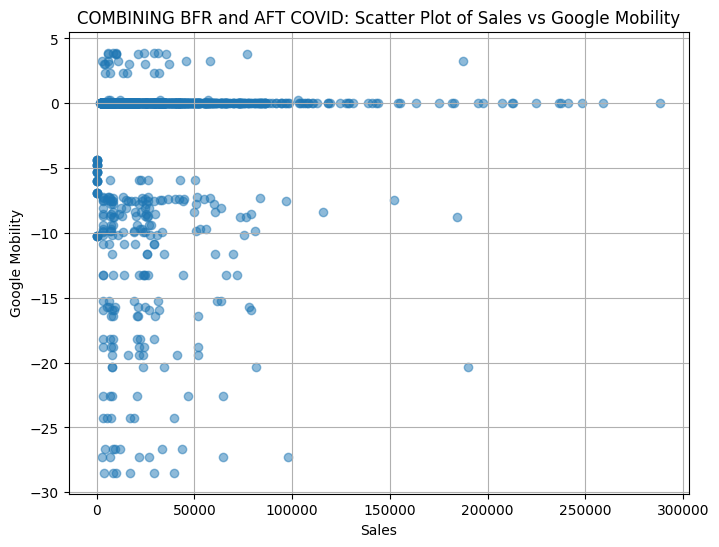

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = df.toPandas()

sales_column = pandas_df["Sales"]
google_mobility_column = pandas_df["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("COMBINING BFR and AFT COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()


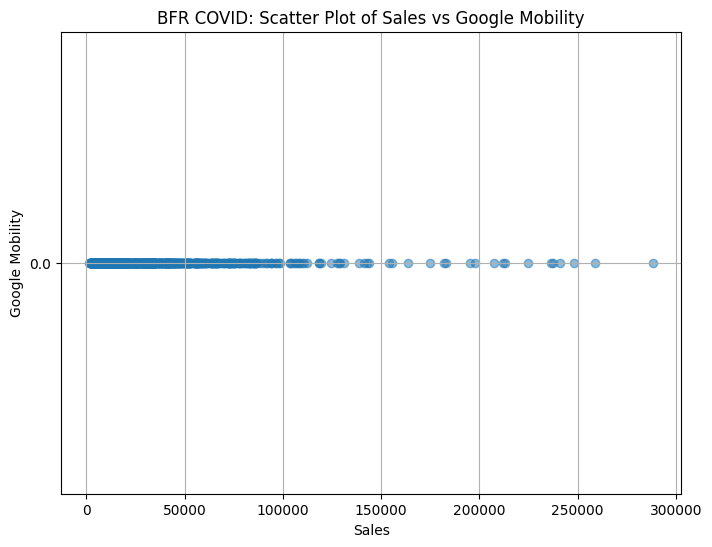

In [ ]:
pandas_df1 = before_date.toPandas()

sales_column = pandas_df1["Sales"]
google_mobility_column = pandas_df1["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("BFR COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

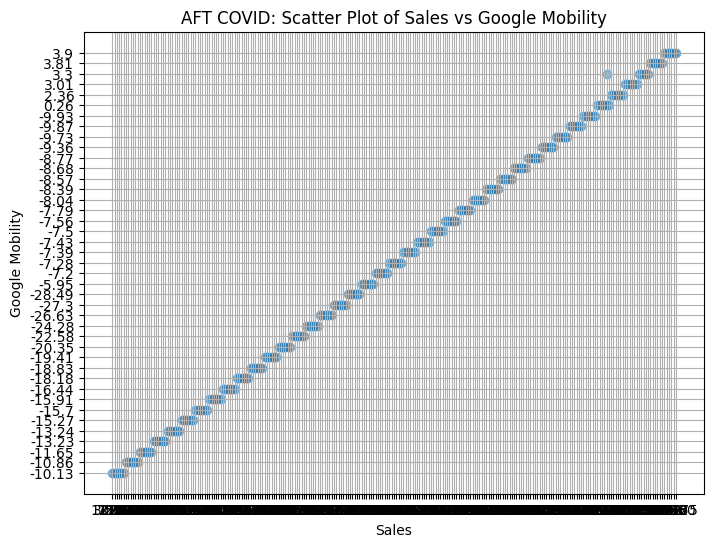

In [ ]:
pandas_df2 = after_date.toPandas()

pandas_df2 = pandas_df2.sort_values(by="Google_Mobility")

sales_column = pandas_df2["Sales"]
google_mobility_column = pandas_df2["Google_Mobility"]

plt.figure(figsize=(8, 6))
plt.scatter(sales_column, google_mobility_column, alpha=0.5)
plt.title("AFT COVID: Scatter Plot of Sales vs Google Mobility")
plt.xlabel("Sales")
plt.ylabel("Google Mobility")
plt.grid(True)

plt.show()

**Observation**  
As we can see the scatter plot, there is correlation between Sales and Google Mobility in after Covid. This is because Google Mobility records how much people actively go outside that relates with the sales how much the beverage company can sell.  
On the other hand, there is no correlation in before Covid.  

In [ ]:
cross_tab = df.crosstab("Product", "Covid_flag")
print(cross_tab)

DataFrame[Product_Covid_flag: string, 0: bigint, 1: bigint]


**Recommendation**  
Since the sales of the bebarage company is too differnt between before Covid and after Covid, we recommend to use the data after Covid to build model and demostrate accuracy for Q3-Q4 of 2020.  
If we include the data with before Covid, that is totaly different circumstance that will provides inaccurate prediction.  
However, in term of exploring more opportunities to be able to use multiplie methods, we also recommend to use entire of dataset. This is because only EDA can't fugure it out the accurate insights.  